# LGBM을 활용한 베이스라인
- jh, cw, dh 모두 concat

In [ ]:
# !pip install bayesian-optimization

In [2]:
import pandas as pd
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings            
warnings.filterwarnings("ignore")

## 1. 데이터 로딩

In [34]:
# df_jh_1 = pd.read_csv('/opt/ml/code/Lgbm/dataset/jh_train.csv')
# df_jh_1

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,level,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,item_ans_rate,rank_point,user_correct_answer,user_total_answer,user_acc,user_correct_answer_tag,user_total_answer_tag,user_acc_tag,sec_time,solve_time,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,grade,test_level
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,4,0.384000,0.400000,0.378667,0.984000,1000.0,NaN,0,NaN,NaN,0,NaN,1585009031,3.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,6,6.984000
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,4,0.376000,0.400533,0.378667,0.968000,1000.0,1.0,1,1.00,NaN,0,NaN,1585009034,3.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,6,6.968000
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,4,0.376000,0.400533,0.378667,0.916000,1000.0,2.0,2,1.00,1.0,1,1.00,1585009042,8.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,6,6.916000
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,0.392000,0.400533,0.378667,0.972000,1000.0,3.0,3,1.00,2.0,2,1.00,1585009049,7.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,6,6.972000
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,0.376000,0.400533,0.378667,0.948000,1000.0,4.0,4,1.00,3.0,3,1.00,1585009056,7.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,6,6.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,0.186667,0.255556,0.236000,0.446667,990.0,1.0,4,0.25,1.0,4,0.25,1591339821,24.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,3,3.446667
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,3,0.333333,0.315637,0.330275,0.643333,1000.0,NaN,0,NaN,NaN,0,NaN,1597971999,17.5,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,4,4.643333
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,3,0.333333,0.315637,0.330275,0.640000,1001.0,1.0,1,1.00,1.0,1,1.00,1597972010,11.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,4,4.640000
2525954,2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3,0.366667,0.315637,0.330275,0.786667,1002.0,2.0,2,1.00,2.0,2,1.00,1597972056,46.0,61.211157,143.231680,8.814474,34.720000,148.986234,13.786687,59.083673,150.289588,10.116005,4,4.786667


In [3]:
df_cw = pd.read_csv('/opt/ml/code/Lgbm/dataset/cw_train.csv')
df_jh = pd.read_csv('/opt/ml/code/Lgbm/dataset/jh_train_v3.csv')
df_dh = pd.read_csv('/opt/ml/code/Lgbm/dataset/dh_train.csv')

In [3]:
# data_dir = '/opt/ml/input/data/train_dataset'
# csv_file_path = os.path.join(data_dir, 'train_data.csv')
# df = pd.read_csv(csv_file_path) 

In [42]:
df_jh

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,user_correct_answer,user_total_answer,user_acc,user_correct_answer_tag,user_total_answer_tag,user_acc_tag,sec_time,solve_time,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_level,item_ans_Rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.384000,0.400000,0.378667,1000.0,NaN,0,NaN,NaN,0,NaN,1585009031,3.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,6.984000,0.984000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.376000,0.400533,0.378667,1000.0,1.0,1,1.00,NaN,0,NaN,1585009034,3.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,6.968000,0.968000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.376000,0.400533,0.378667,1000.0,2.0,2,1.00,1.0,1,1.00,1585009042,8.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,6.916000,0.916000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.392000,0.400533,0.378667,1000.0,3.0,3,1.00,2.0,2,1.00,1585009049,7.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,6.972000,0.972000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.376000,0.400533,0.378667,1000.0,4.0,4,1.00,3.0,3,1.00,1585009056,7.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.186667,0.255556,0.236000,990.0,1.0,4,0.25,1.0,4,0.25,1591339821,24.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,3.446667,0.446667
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.333333,0.315637,0.330275,1000.0,NaN,0,NaN,NaN,0,NaN,1597971999,17.5,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,4.643333,0.643333
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.333333,0.315637,0.330275,1001.0,1.0,1,1.00,1.0,1,1.00,1597972010,11.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,4.640000,0.640000
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.366667,0.315637,0.330275,1002.0,2.0,2,1.00,2.0,2,1.00,1597972056,46.0,61.211157,143.231680,8.814474,34.720000,148.986234,13.786687,59.083673,150.289588,10.116005,4.786667,0.786667


In [4]:
df_dh = df_dh.loc[:, ['userID', 'assessmentItemID','Timestamp','sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew','problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew']]
df_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,...,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,0,A060001001,2020-03-24 00:17:11,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,...,57.989333,2.987606,38.610421,90.048179,11.416101,1.0,3.0,46.773103,132.415930,12.619452
1,0,A060001002,2020-03-24 00:17:14,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,...,35.571643,9.226392,32.801499,97.199085,12.374465,2.0,6.0,46.773103,132.415930,12.619452
2,0,A060001003,2020-03-24 00:17:22,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,...,50.599334,6.906363,32.801499,97.199085,12.374465,3.0,14.0,46.773103,132.415930,12.619452
3,0,A060001004,2020-03-24 00:17:29,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,...,27.686201,4.361576,32.801499,97.199085,12.374465,4.0,21.0,46.773103,132.415930,12.619452
4,0,A060001005,2020-03-24 00:17:36,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,...,35.668124,7.749055,32.801499,97.199085,12.374465,5.0,28.0,46.773103,132.415930,12.619452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7439,A040197006,2020-08-21 07:39:45,1597995585,5.0,7.357143,17.491197,0.773081,1390.0,0.953020,...,29.534217,5.164544,45.088619,131.331031,12.123556,6.0,302.0,36.500000,42.973829,2.495861
2525952,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,...,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.500000,42.973829,2.495861
2525953,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,...,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.500000,42.973829,2.495861
2525954,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,...,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.500000,42.973829,2.495861


In [44]:
df_dh.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew', 'user_total_correct_cnt',
       'user_total_ans_cnt', 'user_total_acc', 'test_size', 'retest',
       'user_test_ans_cnt', 'user_test_correct_cnt', 'user_acc', 'test_level',
       'problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew'],
      dtype='object')

In [4]:
df_jh.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'user_correct_answer_tag', 'user_total_answer_tag', 'user_acc_tag',
       'sec_time', 'solve_time', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew', 'test_level', 'item_ans_Rate'],
      dtype='object')

In [5]:
# df_jh = df_jh.loc[:, ['userID', 'assessmentItemID',
#        'Timestamp','level', 'test_level_diff_itemID','test_level_diff_KnowledgeTag', 'test_level_diff_testId','item_ans_rate']]
df_jh = df_jh.loc[:, ['userID', 'assessmentItemID','Timestamp','test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point','test_level', 'item_ans_Rate']]
df_jh

,userID,assessmentItemID,Timestamp,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,A060001001,2020-03-24 00:17:11,0.384000,0.400000,0.378667,1000.0,6.984000,0.984000
1,0,A060001002,2020-03-24 00:17:14,0.376000,0.400533,0.378667,1000.0,6.968000,0.968000
2,0,A060001003,2020-03-24 00:17:22,0.376000,0.400533,0.378667,1000.0,6.916000,0.916000
3,0,A060001004,2020-03-24 00:17:29,0.392000,0.400533,0.378667,1000.0,6.972000,0.972000
4,0,A060001005,2020-03-24 00:17:36,0.376000,0.400533,0.378667,1000.0,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,2020-06-05 06:50:21,0.186667,0.255556,0.236000,990.0,3.446667,0.446667
2525952,7441,A040165001,2020-08-21 01:06:39,0.333333,0.315637,0.330275,1000.0,4.643333,0.643333
2525953,7441,A040165002,2020-08-21 01:06:50,0.333333,0.315637,0.330275,1001.0,4.640000,0.640000
2525954,7441,A040165003,2020-08-21 01:07:36,0.366667,0.315637,0.330275,1002.0,4.786667,0.786667


In [8]:
# df_dh = df_dh.drop(['testId','answerCode','KnowledgeTag','user_total_correct_cnt','user_total_ans_cnt','user_total_acc','user_test_ans_cnt','user_test_correct_cnt','user_acc'], axis=1)
# df_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,...,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,0,A060001001,2020-03-24 00:17:11,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,...,90.048179,11.416101,6.0,0.0,6.0,1.0,3.0,46.773103,132.415930,12.619452
1,0,A060001002,2020-03-24 00:17:14,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,...,97.199085,12.374465,6.0,0.0,6.0,2.0,6.0,46.773103,132.415930,12.619452
2,0,A060001003,2020-03-24 00:17:22,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,...,97.199085,12.374465,6.0,0.0,6.0,3.0,14.0,46.773103,132.415930,12.619452
3,0,A060001004,2020-03-24 00:17:29,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,...,97.199085,12.374465,6.0,0.0,6.0,4.0,21.0,46.773103,132.415930,12.619452
4,0,A060001005,2020-03-24 00:17:36,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,...,97.199085,12.374465,6.0,0.0,6.0,5.0,28.0,46.773103,132.415930,12.619452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7439,A040197006,2020-08-21 07:39:45,1597995585,5.0,7.357143,17.491197,0.773081,1390.0,0.953020,...,131.331031,12.123556,6.0,0.0,4.0,6.0,302.0,36.500000,42.973829,2.495861
2525952,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,...,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.500000,42.973829,2.495861
2525953,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,...,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.500000,42.973829,2.495861
2525954,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,...,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.500000,42.973829,2.495861


In [5]:
# test data, train에 추가하기(concat)

In [6]:
# test_train = pd.read_csv('/opt/ml/input/data/train_dataset/test_data.csv')

In [6]:
pd.options.display.max_columns = 1000
df = pd.merge(df_cw, df_dh, on=['userID','assessmentItemID','Timestamp'])
df = pd.merge(df, df_jh, on=['userID','assessmentItemID','Timestamp'])
df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,1.0,3.0,46.773103,132.415930,12.619452,0.384000,0.400000,0.378667,1000.0,6.984000,0.984000
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,2.0,6.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.968000,0.968000
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,3.0,14.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.916000,0.916000
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,4.0,21.0,46.773103,132.415930,12.619452,0.392000,0.400533,0.378667,1000.0,6.972000,0.972000
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,5.0,28.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4,1591339821,24.0,64.511004,110.552239,0.666000,999.0,0.446667,134.0,0.694889,3127.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,5.0,282.5,47.777778,34.369419,1.322494,0.186667,0.255556,0.236000,990.0,3.446667,0.446667
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4,1597971999,17.5,53.026480,50.129669,0.653878,784.0,0.643333,193.0,0.700029,2413.0,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,1.0,17.5,47.777778,34.369419,1.322494,0.333333,0.315637,0.330275,1000.0,4.643333,0.643333
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4,1597972010,11.0,51.189815,43.744792,0.653878,784.0,0.640000,192.0,0.700029,2413.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,2.0,28.5,47.777778,34.36941

In [7]:
# nan값 처리하기
df['user_acc'] = df['user_acc'].fillna(0)
df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,0.000000,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,1.0,3.0,46.773103,132.415930,12.619452,0.384000,0.400000,0.378667,1000.0,6.984000,0.984000
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,2.0,6.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.968000,0.968000
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,3.0,14.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.916000,0.916000
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,4.0,21.0,46.773103,132.415930,12.619452,0.392000,0.400533,0.378667,1000.0,6.972000,0.972000
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,5.0,28.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4,1591339821,24.0,64.511004,110.552239,0.666000,999.0,0.446667,134.0,0.694889,3127.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,5.0,282.5,47.777778,34.369419,1.322494,0.186667,0.255556,0.236000,990.0,3.446667,0.446667
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4,1597971999,17.5,53.026480,50.129669,0.653878,784.0,0.643333,193.0,0.700029,2413.0,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,1.0,17.5,47.777778,34.369419,1.322494,0.333333,0.315637,0.330275,1000.0,4.643333,0.643333
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4,1597972010,11.0,51.189815,43.744792,0.653878,784.0,0.640000,192.0,0.700029,2413.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,2.0,28.5,47.777778,34.

In [50]:
df.isnull().sum()  #결측치 없음

Unnamed: 0                      0
userID                          0
assessmentItemID                0
testId                          0
answerCode                      0
Timestamp                       0
KnowledgeTag                    0
index                           0
user_correct_answer             0
user_total_answer               0
user_acc                        0
u_test_cnt                      0
test_ans_cnt                    0
test_ans_rate                   0
u_tag_cnt                       0
tag_ans_cnt                     0
tag_ans_rate                    0
test_rate                       0
grade                           0
grade_test_level                0
que_rate                        0
que_num                         0
que_num_rate                    0
tag_rate                        0
user_grade                      0
sec_time                        0
solve_time                      0
wrongP_time                     0
correctP_time                   0
test_mean     

In [15]:
# df = df.drop(['user_total_correct_cnt','user_total_ans_cnt','user_total_acc','user_test_ans_cnt','user_test_correct_cnt','user_acc_y'],axis=1)
# df.rename(columns = {'user_acc_x' : 'user_acc'}, inplace = True)
# df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,6.0,0.0,6.0,1.0,3.0,46.773103,132.415930,12.619452
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,6.0,0.0,6.0,2.0,6.0,46.773103,132.415930,12.619452
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,6.0,0.0,6.0,3.0,14.0,46.773103,132.415930,12.619452
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,6.0,0.0,6.0,4.0,21.0,46.773103,132.415930,12.619452
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,6.0,0.0,6.0,5.0,28.0,46.773103,132.415930,12.619452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4,1591339821,24.0,64.511004,110.552239,0.666000,999.0,0.446667,134.0,0.694889,3127.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,5.0,0.0,3.0,5.0,282.5,47.777778,34.369419,1.322494
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4,1597971999,17.5,53.026480,50.129669,0.653878,784.0,0.643333,193.0,0.700029,2413.0,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,4.0,0.0,4.0,1.0,17.5,47.777778,34.369419,1.322494
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4,1597972010,11.0,51.189815,43.744792,0.653878,784.0,0.640000,192.0,0.700029,2413.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,4.0,0.0,4.0,2.0,28.5,47.777778,34.369419,1.322494
2525954,2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29,0.79,3,0.69,0.70,4,1597972056,46.0,33.156250,35.144068,0.653878,784.0,0.786667,236.0,0.700029,2413.0,61.211157,143.231680,8.814474,34.720000,148.986234,13.786687,59.083673,150.289588,10.116005,4.0,0.0,4.0,3.0,74.5,47.777778,34

In [7]:
# test_train = test_train[test_train['answerCode'] != -1]

In [8]:
# df = pd.concat([df,test_train])
# df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244


### test dataset 만들기

In [8]:
# test data concat
test_cw = pd.read_csv('/opt/ml/code/Lgbm/dataset/cw_test.csv')
test_jh = pd.read_csv('/opt/ml/code/Lgbm/dataset/jh_test_v3.csv')
test_dh = pd.read_csv('/opt/ml/code/Lgbm/dataset/dh_test.csv')

In [9]:
# df_jh = df_jh.loc[:, ['userID', 'assessmentItemID',
#        'Timestamp','level', 'test_level_diff_itemID','test_level_diff_KnowledgeTag', 'test_level_diff_testId','item_ans_rate']]
test_jh = test_jh.loc[:, ['userID', 'assessmentItemID', 'Timestamp', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point','test_level', 'item_ans_Rate']]
test_jh

,userID,assessmentItemID,Timestamp,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,3,A050023001,2020-01-09 10:56:31,0.192000,0.214857,0.197714,1000.0,5.660000,0.660000
1,3,A050023002,2020-01-09 10:56:57,0.200000,0.214857,0.197714,998.0,5.620000,0.620000
2,3,A050023003,2020-01-09 10:58:31,0.216000,0.232000,0.197714,998.0,5.548000,0.548000
3,3,A050023004,2020-01-09 10:58:36,0.176000,0.232000,0.197714,993.0,5.636000,0.636000
4,3,A050023006,2020-01-09 10:58:43,0.152000,0.222222,0.197714,993.0,5.304000,0.304000
...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,2020-10-14 23:07:23,0.193333,0.229715,0.245497,989.0,4.436667,0.436667
260110,7439,A040130002,2020-10-14 23:07:41,0.193333,0.229715,0.245497,991.0,4.483333,0.483333
260111,7439,A040130003,2020-10-14 23:08:02,0.293333,0.267112,0.245497,992.0,4.846667,0.846667
260112,7439,A040130004,2020-10-14 23:09:31,0.286667,0.267112,0.245497,992.0,4.830000,0.830000


In [53]:
test_jh.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'sec_time', 'solve_time', 'rank_point',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'user_correct_answer_tag', 'user_total_answer_tag', 'user_acc_tag',
       'test_level_diff_itemID', 'test_level_diff_KnowledgeTag',
       'test_level_diff_testId', 'test_level', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'item_ans_Rate'],
      dtype='object')

In [55]:
test_dh.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew', 'user_total_correct_cnt',
       'user_total_ans_cnt', 'user_total_acc', 'test_size', 'retest',
       'user_test_ans_cnt', 'user_test_correct_cnt', 'user_acc', 'test_level',
       'problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew'],
      dtype='object')

In [10]:
test_dh = test_dh.loc[:, ['userID', 'assessmentItemID','Timestamp','sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew','problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew']]  #'level',

test_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,3,A050023001,2020-01-09 10:56:31,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,1.0,26.0,61.148649,108.448444,9.761547
1,3,A050023002,2020-01-09 10:56:57,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,2.0,52.0,61.148649,108.448444,9.761547
2,3,A050023003,2020-01-09 10:58:31,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,3.0,146.0,61.148649,108.448444,9.761547
3,3,A050023004,2020-01-09 10:58:36,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,4.0,151.0,61.148649,108.448444,9.761547
4,3,A050023006,2020-01-09 10:58:43,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,6.0,158.0,61.148649,108.448444,9.761547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.218750,41.531903,2.579163
260110,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.218750,41.531903,2.579163
260111,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.218750,41.531903,2.579163
260112,7439,A040130004,2020-10-14 23:09:31,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,249.0,0.765442,917.0,64.891324,139.460022,9.389976,72.882244,135.040350,4.853693,56.244580,143.539425,8.551274,4.0,139.5,36.218750,41.531903,2.579163


In [16]:
# test_dh = test_dh.drop(['testId','answerCode','KnowledgeTag','user_total_correct_cnt','user_total_ans_cnt','user_total_acc','user_test_ans_cnt','user_test_correct_cnt','user_acc'], axis=1)
# test_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,3,A050023001,2020-01-09 10:56:31,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,7.0,0.0,5.0,1.0,26.0,61.148649,108.448444,9.761547
1,3,A050023002,2020-01-09 10:56:57,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,7.0,0.0,5.0,2.0,52.0,61.148649,108.448444,9.761547
2,3,A050023003,2020-01-09 10:58:31,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,7.0,0.0,5.0,3.0,146.0,61.148649,108.448444,9.761547
3,3,A050023004,2020-01-09 10:58:36,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,7.0,0.0,5.0,4.0,151.0,61.148649,108.448444,9.761547
4,3,A050023006,2020-01-09 10:58:43,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,7.0,0.0,5.0,6.0,158.0,61.148649,108.448444,9.761547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.218750,41.531903,2.579163
260110,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.218750,41.531903,2.579163
260111,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.218750,41.531903,2.579163
260112,7439,A040130004,2020-10-14 23:09:31,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,249.0,0.765442,917.0,64.891324,139.460022,9.389976,72.882244,135.040350,4.853693,56.244580,143.539425,8.551274,5.0,0.0,4.0,4.0,139.5,36.218750,41.531903,2.579163


In [11]:
pd.options.display.max_columns = 1000
test_df = pd.merge(test_cw, test_dh, on=['userID','assessmentItemID','Timestamp'])
test_df = pd.merge(test_df, test_jh, on=['userID','assessmentItemID','Timestamp'])
test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,1.0,26.0,61.148649,108.448444,9.761547,0.192000,0.214857,0.197714,1000.0,5.660000,0.660000
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,2.0,52.0,61.148649,108.448444,9.761547,0.200000,0.214857,0.197714,998.0,5.620000,0.620000
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,3.0,146.0,61.148649,108.448444,9.761547,0.216000,0.232000,0.197714,998.0,5.548000,0.548000
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,4.0,151.0,61.148649,108.448444,9.761547,0.176000,0.232000,0.197714,993.0,5.636000,0.636000
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,6.0,158.0,61.148649,108.448444,9.761547,0.152000,0.222222,0.197714,993.0,5.304000,0.304000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,989.0,4.436667,0.436667
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,991.0,4.483333,0.483333
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.218750,41.531903,2.579163,0.293333,0.267112,0.24

In [37]:
# test_df = test_df.merge(all_user_grade, on='userID', how='left')

# test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,user_grade
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,7.0,0.0,5.0,1.0,26.0,61.148649,108.448444,9.761547,5
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,7.0,0.0,5.0,2.0,52.0,61.148649,108.448444,9.761547,5
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,7.0,0.0,5.0,3.0,146.0,61.148649,108.448444,9.761547,5
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,7.0,0.0,5.0,4.0,151.0,61.148649,108.448444,9.761547,5
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,7.0,0.0,5.0,6.0,158.0,61.148649,108.448444,9.761547,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.218750,41.531903,2.579163,4
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.218750,41.531903,2.579163,4
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.218750,41.531903,2.579163,4
260112,260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,260112,10.0,14,0.714286,3,2.0,0.67,1,1.0,1.0,0.64,4,30,0.83,4,0.66,0.77,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,249.0,0.765442,917.0,64.891324,139.460022,9.389976,72.882244,135.040350,4.853693,56.244580,143.539425,8.551274,5.0,0.0,4.0,4.0,139.5,36.218750,41.53

In [12]:
test_df['user_acc'] = test_df['user_acc'].fillna(0)
test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,0.000000,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,1.0,26.0,61.148649,108.448444,9.761547,0.192000,0.214857,0.197714,1000.0,5.660000,0.660000
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,2.0,52.0,61.148649,108.448444,9.761547,0.200000,0.214857,0.197714,998.0,5.620000,0.620000
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,3.0,146.0,61.148649,108.448444,9.761547,0.216000,0.232000,0.197714,998.0,5.548000,0.548000
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,4.0,151.0,61.148649,108.448444,9.761547,0.176000,0.232000,0.197714,993.0,5.636000,0.636000
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,6.0,158.0,61.148649,108.448444,9.761547,0.152000,0.222222,0.197714,993.0,5.304000,0.304000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,989.0,4.436667,0.436667
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,991.0,4.483333,0.483333
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.218750,41.531903,2.579163,0.293333,0.267112

In [26]:
test_df.isnull().sum()

Unnamed: 0                      0
userID                          0
assessmentItemID                0
testId                          0
answerCode                      0
Timestamp                       0
KnowledgeTag                    0
index                           0
user_correct_answer             0
user_total_answer               0
user_acc                        0
u_test_cnt                      0
test_ans_cnt                    0
test_ans_rate                   0
u_tag_cnt                       0
tag_ans_cnt                     0
tag_ans_rate                    0
test_rate                       0
grade                           0
grade_test_level                0
que_rate                        0
que_num                         0
que_num_rate                    0
tag_rate                        0
sec_time                        0
solve_time                      0
wrongP_time                     0
correctP_time                   0
test_mean                       0
test_sum      

In [ ]:
test_df[test_df['user_id'] ]

In [22]:
# df.to_csv('all_train.csv')
# test_df.to_csv('all_test.csv')

## 2. Feature Engineering

In [9]:
# 문항 번호별 정답률 feature
def que_num_rate(df) :
    
    train_df = df.groupby(['que_num'])['que_num'].count().reset_index(name='que_num_cnt')
    train_ans_df = df.groupby(['que_num'])['answerCode'].sum().reset_index(name='que_ans_cnt')
    train_df = train_df.merge(train_ans_df, on ='que_num', how='left')
    train_df['que_num_rate'] = round(train_df['que_ans_cnt'] / train_df['que_num_cnt'], 2)

    return train_df.loc[:,['que_num','que_num_rate']]


In [10]:
# last Tag에 대한 정답률 함수 생성
def last_tag_rate(df):
    df = df.copy()
    
    last_tag = df.groupby(['userID']).tail(1)
    last_tag_1 = last_tag.loc[:, ['userID','KnowledgeTag']]
    
    user_tag_ans = last_tag_1.merge(df, on=['userID','KnowledgeTag'], how='left')
    
    user_tag_ans['count'] = user_tag_ans.groupby(['userID','KnowledgeTag'])['KnowledgeTag'].transform('count')
    user_tag_ans['tag_cnt'] = user_tag_ans['count']-1
    user_tag_ans['ans_cnt'] = user_tag_ans.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    
    user_tag_ans_rate = user_tag_ans.groupby('userID').tail(1)
    user_tag_ans_rate['ans_cnt'] = user_tag_ans_rate['ans_cnt'].fillna(0)
    user_tag_ans_rate['last_ans_rate'] = round(user_tag_ans_rate['ans_cnt']/ user_tag_ans_rate['tag_cnt'],2)
    user_tag_ans_rate['last_ans_rate'] = user_tag_ans_rate['last_ans_rate'].fillna(0.00)
    
    return user_tag_ans_rate.loc[:,['userID','last_ans_rate']]

In [11]:
def user_test_rate(df):
#     df['index'] = df.index
    u_test_cnt = df.groupby(['userID','testId'])['testId'].cumcount().reset_index(name='u_test_cnt')
    user_test = df.merge(u_test_cnt, on='index', how='left')
    u_test_cnt= user_test.groupby(['userID','testId'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).reset_index(name='test_ans_cnt')
    user_test_ans_sum =  user_test.merge(u_test_cnt, on='index', how='left')
    user_test_ans_sum['test_ans_cnt'] = user_test_ans_sum['test_ans_cnt'].fillna(0.0)
    
    def rating_1(user_test_ans_sum):
        if user_test_ans_sum['u_test_cnt'] == 0:
            return 0.50
        else :    
            return round(user_test_ans_sum['test_ans_cnt']/user_test_ans_sum['u_test_cnt'],2)
        
    user_test_ans_sum['test_ans_rate'] = user_test_ans_sum.apply(rating_1, axis=1)
    
    return user_test_ans_sum.loc[:,['index','u_test_cnt','test_ans_cnt','test_ans_rate']]

In [12]:
# user별 Tag에 대한 정답률 sequential하게 적용
def user_tag_rate(df) :
#     df['index'] = df.index

    u_t_cnt = df.groupby(['userID','KnowledgeTag'])['KnowledgeTag'].cumcount().reset_index(name='u_tag_cnt')
    user_tag =  df.merge(u_t_cnt, on='index', how='left')
    #user_tag['tag_cnt_1'] = user_tag['u_tag_cnt']+1

    u_t_cnt= user_tag.groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).reset_index(name='ans_cnt')
    user_tag_ans_sum =  user_tag.merge(u_t_cnt, on='index', how='left')
    user_tag_ans_sum['ans_cnt'] = user_tag_ans_sum['ans_cnt'].fillna(0.0)

    def rating(user_tag_ans_sum):
        if user_tag_ans_sum['u_tag_cnt'] == 0:
            return 0.50
        else :    
            return round(user_tag_ans_sum['ans_cnt']/user_tag_ans_sum['u_tag_cnt'],2)
    user_tag_ans_sum['tag_ans_rate'] = user_tag_ans_sum.apply(rating, axis=1)
    
    return user_tag_ans_sum.loc[:,['index','u_tag_cnt','ans_cnt','tag_ans_rate']]

In [13]:
def test_rate(df):
    test_df = df.groupby(['testId'])['testId'].count().reset_index(name='test_cnt')
    test_ans_df = df.groupby(['testId'])['answerCode'].sum().reset_index(name='test_ans_cnt')
    test_df = test_df.merge(test_ans_df, on ='testId', how='left')
    test_df['test_rate'] = round(test_df['test_ans_cnt'] / test_df['test_cnt'], 2)
    test_df['test_rate'] = test_df['test_rate'].fillna(0.00)
    return test_df.loc[:,['testId','test_rate']]

def que_rate(df):
    que_df = df.groupby(['assessmentItemID'])['assessmentItemID'].count().reset_index(name='que_cnt')
    que_ans_df = df.groupby(['assessmentItemID'])['answerCode'].sum().reset_index(name='que_ans_cnt')
    que_df = que_df.merge(que_ans_df, on ='assessmentItemID', how='left')
    que_df['que_rate'] = round(que_df['que_ans_cnt'] / que_df['que_cnt'], 2)
    que_df['que_rate'] = que_df['que_rate'].fillna(0.00)
    return que_df.loc[:,['assessmentItemID','que_rate']]

def tag_rate(df):
    tag_df = df.groupby(['KnowledgeTag'])['KnowledgeTag'].count().reset_index(name='tag_cnt')
    tag_ans_df = df.groupby(['KnowledgeTag'])['answerCode'].sum().reset_index(name='tag_ans_cnt')
    tag_df = tag_df.merge(tag_ans_df, on ='KnowledgeTag', how='left')
    tag_df['tag_rate'] = round(tag_df['tag_ans_cnt'] / tag_df['tag_cnt'], 2)
    tag_df['tag_rate'] = tag_df['tag_rate'].fillna(0.00)
    return tag_df.loc[:,['KnowledgeTag','tag_rate']]

In [14]:
def rating_1(df):
    if df['u_test_cnt'] == 0:
        return 0.50
    else :    
        return round(df['test_ans_cnt']/df['u_test_cnt'],2)
    
def rating_2(df):
    if df['u_tag_cnt'] == 0:
        return 0.50
    else :    
        return round(df['tag_ans_cnt']/df['u_tag_cnt'],2)

In [15]:
def feature_engineering(df):
    
    df['index'] = df.index
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
#     correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
#     correct_t.columns = ["test_mean", 'test_sum']
#     correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
#     correct_k.columns = ["tag_mean", 'tag_sum']

#     df = pd.merge(df, correct_t, on=['testId'], how="left")
#     df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    
    # user_test_ans_rate
    df['u_test_cnt'] = df.groupby(['userID','testId'])['answerCode'].cumcount()
    df['test_ans_cnt'] = df.groupby(['userID','testId'])['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['test_ans_cnt'] = df['test_ans_cnt'].fillna(0.0)
    df['test_ans_rate'] = df.apply(rating_1, axis=1)
    
    # user_tag_seq_ans_rate
    df['u_tag_cnt'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].cumcount()
    df['tag_ans_cnt'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['tag_ans_cnt'] = df['tag_ans_cnt'].fillna(0.0)
    df['tag_ans_rate'] = df.apply(rating_2, axis=1)
    #####################################################################################
#     # user_test_ans_rate
#     user_test_ans_rate = user_test_rate(df)
#     df = pd.merge(df, user_test_ans_rate, on='index', how='left')
    
#     # user_tag_seq_ans_rate
#     user_tag_ans_rate = user_tag_rate(df)
#     df = pd.merge(df, user_tag_ans_rate, on='index', how='left')
    ####################################################################################
    
    
#     # last_Tag ans rate
#     last_tag_ans_rate = last_tag_rate(df)
#     df = pd.merge(df, last_tag_ans_rate, on=['userID'], how='left')
    
    # test별 정답률
#     all_test_rate = test_rate(df)
#     df = pd.merge(df, all_test_rate, on='testId', how='left')
    
    # 문항의 순서별 정답률
#     df['que_num'] = df['assessmentItemID'].str.slice(start=7, stop=10)
#     df['que_num'] = df['que_num'].astype(int)
#     que_num_df = que_num_rate(df)
#     df = df.merge(que_num_df, on='que_num', how='left')
    
    
    # 문제별 정답률
#     all_que_rate = que_rate(df)
#     df = pd.merge(df, all_que_rate, on='assessmentItemID', how='left')
    
    # Tag별 정답률
#     all_tag_rate = tag_rate(df)
#     df = pd.merge(df, all_tag_rate, on='KnowledgeTag', how='left')
    
    

    
    return df

In [16]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,NaN,0,NaN,0,0.0,0.5,0,0.0,0.5
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.0,1,1.0,1.0,0,0.0,0.5
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.0,2,2.0,1.0,1,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.0,3,3.0,1.0,2,2.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.0,4,4.0,1.0,3,3.0,1.0


In [257]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29,0.79,3,0.69,0.70,4


In [248]:
df.to_csv('cw_train.csv')

In [17]:
def grade_test_level(df):
    df = test_rate(df)
    df['grade'] = df['testId'].str.slice(start=2, stop=3)
    df['grade_test_level'] = df.groupby(['grade'])['test_rate'].rank(method='dense', ascending=False)
    df['grade_test_level'] = df['grade_test_level'].astype(int)
    return df


In [18]:
grade_test_level = grade_test_level(df)
grade_test_level

,testId,test_rate,grade,grade_test_level
0,A010000001,0.92,1,4
1,A010000002,0.93,1,3
2,A010000003,0.84,1,12
3,A010000004,0.88,1,8
4,A010000005,0.85,1,11
...,...,...,...,...
1532,A090000070,0.46,9,12
1533,A090000071,0.34,9,23
1534,A090000072,0.45,9,13
1535,A090000073,0.54,9,6


In [19]:
df = df.merge(grade_test_level, on='testId', how='left')
df['grade'] = df['grade'].astype(int)
df['user_correct_answer'] = df['user_correct_answer'].fillna(0)

# test_rate
all_test_rate = test_rate(df)
# df = pd.merge(df, all_test_rate, on='testId', how='left')

# que_rate
all_que_rate = que_rate(df)
df = pd.merge(df, all_que_rate, on='assessmentItemID', how='left')

# que_num_rate
df['que_num'] = df['assessmentItemID'].str.slice(start=7, stop=10)
df['que_num'] = df['que_num'].astype(int)
que_num_df = que_num_rate(df)
df = df.merge(que_num_df, on='que_num', how='left')

# tag_rate
all_tag_rate = tag_rate(df)
df = pd.merge(df, all_tag_rate, on='KnowledgeTag', how='left')

In [184]:
# df.to_csv('train_data_fe.csv')

In [23]:
pd.options.display.max_columns = 1000
df[:10]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,5,5.0,5,1.000000,5,5.0,1.00,4,4.0,1.00,0.95,6,1,0.93,7,0.52,0.92
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,6,6.0,6,1.000000,0,0.0,0.50,0,0.0,0.50,0.79,6,14,0.89,1,0.75,0.80
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,7,6.0,7,0.857143,1,0.0,0.00,1,0.0,0.00,0.79,6,14,0.93,2,0.72,0.80
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,8,7.0,8,0.875000,2,1.0,0.50,2,1.0,0.50,0.79,6,14,0.52,3,0.69,0.80
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,9,8.0,9,0.888889,3,2.0,0.67,3,2.0,0.67,0.79,6,14,0.82,4,0.66,0.80


In [ ]:
# df[(df['userID'] == 7440) & (df['testId'] == 'A030000136')]

In [ ]:
# df[-10:]

In [ ]:
# df[df['userID']==1]

In [117]:
# df.to_csv('train_data_fe.csv')

## 3. Train/Test 데이터 셋 분리

In [203]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.8, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]
    
    
#     train = train.groupby(['userID','KnowledgeTag']).tail(1)
    #test데이터셋은 각 유저의 마지막 interaction만 추출 (validation)
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [32]:
# 대표 grade값 매기기
def user_grade(df):
    df_train_grade = df.groupby(['userID','grade'])['grade'].count().reset_index(name='grade_cnt')
    train_grade_last = df_train_grade.groupby(['userID'], as_index=False).max()  # 가장 많은 cnt개수 
    train_grade_last['user_grade'] = train_grade_last['grade']
    all_user_grade = train_grade_last.loc[:,['userID','user_grade']]
    return all_user_grade

In [33]:
all_user_grade = user_grade(df)
# df = df.merge(all_user_grade,on='userID', how='left')

In [34]:
all_user_grade

,userID,user_grade
0,0,8
1,1,9
2,2,5
3,3,5
4,4,7
...,...,...
7437,7437,6
7438,7438,8
7439,7439,4
7440,7440,5


In [ ]:
# def print_score(label, pred, prob_thres=0.5):
#     print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
#     print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
#     print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
#     print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

In [20]:
pd.options.display.max_columns = 1000
df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,level,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,item_ans_rate
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,0.000000,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,6.0,0.0,6.0,1.0,3.0,46.773103,132.415930,12.619452,4,0.384000,0.400000,0.378667,0.984000
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,6.0,0.0,6.0,2.0,6.0,46.773103,132.415930,12.619452,4,0.376000,0.400533,0.378667,0.968000
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,6.0,0.0,6.0,3.0,14.0,46.773103,132.415930,12.619452,4,0.376000,0.400533,0.378667,0.916000
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,6.0,0.0,6.0,4.0,21.0,46.773103,132.415930,12.619452,4,0.392000,0.400533,0.378667,0.972000
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,6.0,0.0,6.0,5.0,28.0,46.773103,132.415930,12.619452,4,0.376000,0.400533,0.378667,0.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4,1591339821,24.0,64.511004,110.552239,0.666000,999.0,0.446667,134.0,0.694889,3127.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,5.0,0.0,3.0,5.0,282.5,47.777778,34.369419,1.322494,3,0.186667,0.255556,0.236000,0.446667
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4,1597971999,17.5,53.026480,50.129669,0.653878,784.0,0.643333,193.0,0.700029,2413.0,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,4.0,0.0,4.0,1.0,17.5,47.777778,34.369419,1.322494,3,0.333333,0.315637,0.330275,0.643333
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4,1597972010,11.0,51.189815,43.744792,0.653878,784.0,0.640000,192.0,0.700029,2413.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,4.0,0.0,4.0,2.0

In [23]:
pd.options.display.max_columns = 100
test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,item_ans_rate
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,7.0,0.0,5.0,1.0,26.0,61.148649,108.448444,9.761547,0.192000,0.214857,0.197714,0.750000
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,7.0,0.0,5.0,2.0,52.0,61.148649,108.448444,9.761547,0.200000,0.214857,0.197714,0.562500
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,7.0,0.0,5.0,3.0,146.0,61.148649,108.448444,9.761547,0.216000,0.232000,0.197714,0.343750
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,7.0,0.0,5.0,4.0,151.0,61.148649,108.448444,9.761547,0.176000,0.232000,0.197714,0.500000
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,7.0,0.0,5.0,6.0,158.0,61.148649,108.448444,9.761547,0.152000,0.222222,0.197714,0.281250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,0.380952
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,0.523810
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.218750,41.531903,2.579163,0.293333,0.267112,0.24

In [14]:
test_df.columns

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'index', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew', 'problem_number', 'test_tag_cumsum',
       'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point',
       'test_level', 'item_ans_Rate'],
      dtype='object')

In [13]:
import os,gc
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, accuracy_score

#폴드 개수만큼 user를 쪼갠 목록을 만든다
def lgbm_oof_split_data_withidx(n_fold, df):
    #grade별로 user list 생성 (9개)
    u_g = df.groupby(['userID','user_grade'])['userID'].count().reset_index(name='cnt')   #user별 grade값
    users = [[] for _ in range(10)]  #grade개수총 9개

    for id in u_g['userID']:
        id_grade = int(u_g[u_g['userID'] == id]['user_grade'])  #해당 유저의 grade
        id_cnt = int(u_g[u_g['userID'] == id]['cnt'])
        users[id_grade].append((id, id_cnt))
    
    # grade별로 sorted
    for i in range(1,10):
        user_list = users[i]
        user_list = sorted(user_list, key =lambda x: x[1], reverse=True)
        users[i] = user_list
    

    n_fold = n_fold
    random.seed(37)  # default 42
    user_id_dict=defaultdict(list)
    user_count_dict=defaultdict(int)

    for i in range(1,10):
        gul = users[i]           # gul = grade user list
        random.shuffle(gul)
        for idx, (id, cnt) in enumerate(gul):
            f_num=idx%n_fold
            user_count_dict[f_num] += cnt
            user_id_dict[f_num].append(id)

    return user_id_dict,user_count_dict



#dict들을 통해 원하는 폴드의 train/val set을 가져온다
def get_fold_data(idx,data,user_id_dict,user_count_dict):
    
    train = data[data['userID'].isin(user_id_dict[idx]) == False]  # train
    test = data[data['userID'].isin(user_id_dict[idx])] # validation

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]  #validation
    return train, test




#FE를 진행한 전체 train set과 FE를 진행한 전체 test set, featrue 들을 넣어주시면 됩니다
def make_lgb_user_oof_prediction(train, test, FEATS,  model_params=None, folds=None ):  # categorical_features='auto',
    
#     train.shape[0]  # train 행 총 개수
    
    # fold 생성
    user_id_dict,user_count_dict = lgbm_oof_split_data_withidx(folds, train)
    
    # 마지막 interaction만 추출 (test dataset)
#     test = test[test['userID'] != test['userID'].shift(-1)]  # 마지막 interaction
    test = test[test['answerCode'] == -1]
    x_test = test[FEATS] # 마지막 interaction의 features 값
    
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수 (예측 데이터? 예측값?)
    y_oof = np.zeros(train.shape[0])
    
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    acc=0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = FEATS

    
    for fold in range(folds):

        # train index, validation index로 train 데이터를 나눔
        train_set,valid_set = get_fold_data(fold, train, user_id_dict, user_count_dict)  #개수 잘 나뉘었다.
   

        x_tr, x_val = train_set[FEATS], valid_set[FEATS]    # 정답 외 feature 값들 (마지막 interaction만 X)
        y_tr, y_val = train_set['answerCode'], valid_set['answerCode']  # 정답 부분
    
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        model = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature='auto',
            verbose_eval=100,    
            num_boost_round=5000,
        )

        # Validation 데이터 예측
        val_preds = model.predict(x_val)
        
        # Validation index에 예측값 저장 
#         y_oof[fold] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
#         acc += accuracy_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += model.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = model.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score} ") # 폴드별 Validation 스코어 출력
#     print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
    
    
    
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return test_preds, fi  # 예측 결과, feature 중요도 반환
        
        
        
#         # Validation index에 예측값 저장 
#         y_oof[fold] = val_preds
        
#         # 폴드별 Validation 스코어 측정
#         fold_acc = accuracy_score(y_val, list(map(round,val_preds)))
#         print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)} | ACC: {fold_acc}")
#         print('-'*80)

#         # score 변수에 폴드별 평균 Validation 스코어 저장
#         score += roc_auc_score(y_val, val_preds) / folds
#         acc+=fold_acc / folds
#         # 테스트 데이터 예측하고 평균해서 저장
#         test_preds += model.predict(x_test) / folds
        
#         # 폴드별 피처 중요도 저장
#         fi[f'fold_{fold+1}'] = model.feature_importance()

#         del x_tr, x_val, y_tr, y_val
#         gc.collect()
        
#     print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
#     # print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
    
#     # 폴드별 피처 중요도 평균값 계산해서 저장 
#     fi_cols = [col for col in fi.columns if 'fold_' in col]
#     fi['importance'] = fi[fi_cols].mean(axis=1)
    
    
#     return model, test_preds, fi  #y_oof, 

In [ ]:
# 튜닝 결과
# Trial 32 finished with value: 0.8150008089596779 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 38, 'feature_fraction': 0.6623969601759928, 'bagging_fraction': 0.5877385312344033, 'bagging_freq': 6}. Best is trial 32 with value: 0.8150008089596779.

In [15]:
# FEATS = ['user_acc','u_test_cnt','test_ans_rate','u_tag_cnt','tag_ans_rate','test_rate','grade','grade_test_level','que_rate','que_num_rate','tag_rate','user_grade',
#         'sec_time','solve_time','wrongP_time','correctP_time','test_mean','test_sum','ItemID_mean','ItemID_sum','tag_mean','tag_sum','test_t_mean','test_t_std','test_t_skew','assess_t_mean','assess_t_std','assess_t_skew','tag_t_mean','tag_t_std','tag_t_skew','test_size',
#          'retest','test_level','problem_number','test_tag_cumsum','userID-solve_time-mean','userID-solve_time-std','userID-solve_time-skew'
#         ]
# FEATS = ['user_acc', 'u_test_cnt', 
#        'test_ans_rate', 'u_tag_cnt', 'tag_ans_rate',
#        'que_num_rate', 'tag_rate','test_mean', 'ItemID_mean', 'ItemID_sum',
#        'tag_mean', 'tag_sum',  'test_t_std', 'test_t_skew',
#         'assess_t_std', 'assess_t_skew', 'tag_t_std', 'tag_t_skew', 'test_size', 'test_level',
#        'problem_number', 'test_level_diff_itemID', 'test_level_diff_KnowledgeTag',
#        'test_level_diff_testId', 'item_ans_rate']  # 'level' 없어서 못넣음


FEATS = [
    'user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate','tag_rate', 'sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew', 'problem_number', 'test_tag_cumsum',
       'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 
       'test_level', 'item_ans_Rate'
]  #  'test_ans_cnt', 'grade', 'grade_test_level', 'que_rate', 'que_num', 'que_num_rate', 'rank_point',


model_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'metric':'auc',
        'num_leaves': 100,    #  256,
#         'max_bin': 204,
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': 27,   # 38,
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction':0.6623969601759928,   # 0.6072955014217922,   # 0.6623969601759928,  # 0.46948747908887395
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': 0.8420665969537324,   # 0.5877385312344033,
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': 2,   # 1
#         'n_estimators': 100, # 트리 개수
        'early_stopping_rounds': 100,
#         # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l1': 2.8559537699120116e-06,    #8.755042100872112e-06,       # 0.00010175824628083187
#         # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l2': 2.2432872572212683e-06,   # 0.0015429233553149078,    # 0.0001150682989588032
        'seed': 37,   #37
        'verbose': -1,
        'n_jobs': -1,    
    }


test_preds, fi = make_lgb_user_oof_prediction(df, test_df, FEATS,  model_params, folds=5)  #categorical_features='auto',
# print_score(label, pred, prob_thres=0.5)

fold: 1, x_tr.shape: (2013192, 39), x_val.shape: (1493, 39)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.853997	valid_1's auc: 0.8356
[200]	training's auc: 0.858807	valid_1's auc: 0.838613
[300]	training's auc: 0.862517	valid_1's auc: 0.839884
[400]	training's auc: 0.866152	valid_1's auc: 0.840121
[500]	training's auc: 0.869369	valid_1's auc: 0.840604
Early stopping, best iteration is:
[478]	training's auc: 0.868609	valid_1's auc: 0.840786
Fold 1 | AUC: 0.8407859492692398
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (2032421, 39), x_val.shape: (1491, 39)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.853869	valid_1's auc: 0.83526
[200]	training's auc: 0.858541	valid_1's auc: 0.835669
[300]	training's auc: 0.86217	valid_1's auc: 0.837348
[400]	training's auc: 0.865741	valid_1's auc: 0.837746
Early stopping, best iteration is:
[388]	training's auc: 0.86

In [16]:
fi.sort_values('importance',ascending=False)

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,importance
11,solve_time,2795,2336,1744,1081,1559,1903.0
2,user_acc,2468,2050,1438,733,1397,1617.2
31,userID-solve_time-mean,2521,1979,1292,445,1139,1475.2
16,ItemID_mean,1841,1600,1347,901,1253,1388.4
30,test_tag_cumsum,2146,1744,1213,521,1058,1336.4
33,userID-solve_time-skew,2238,1691,1066,331,975,1260.2
37,test_level,1724,1453,1177,662,1051,1213.4
12,wrongP_time,1656,1431,1127,656,1058,1185.6
32,userID-solve_time-std,2061,1530,1044,254,863,1150.4
13,correctP_time,1540,1345,1009,641,936,1094.2


In [17]:
# Feature importance plot
# def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
# add fig to mlflow
n=40
color='blue'
figsize=(12,8)

fi = fi.sort_values('importance', ascending = False).reset_index(drop = True)

# 피처 중요도 정규화 및 누적 중요도 계산
fi['importance_normalized'] = fi['importance'] / fi['importance'].sum()
fi['cumulative_importance'] = np.cumsum(fi['importance_normalized'])

plt.rcParams['font.size'] = 12
plt.style.use('fivethirtyeight')
# 피처 중요도 순으로 n개까지 바플롯으로 그리기
fi.loc[:n, :].plot.barh(y='importance_normalized', 
                        x='feature', color=color, 
                        edgecolor='k', figsize=figsize,
                        legend=False)

plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
plt.title(f'Top {n} Most Important Features', size=18)
plt.gca().invert_yaxis()

output_dir = '/opt/ml/code/Lgbm/'
task_name = 'lgbm'

new_output_path=f'{output_dir}{task_name}'
write_path = os.path.join(new_output_path, "feature_importance1.png")
if not os.path.exists(new_output_path):
    os.makedirs(new_output_path) 
plt.savefig(write_path,bbox_inches='tight', pad_inches=0.5)
plt.close()   

In [149]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정    user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
FEATS = ['user_acc','u_test_cnt','test_ans_rate','u_tag_cnt','tag_ans_rate','test_rate','grade','grade_test_level','que_rate','que_num_rate','tag_rate']
# FEATS = ['user_acc','u_test_cnt','test_ans_rate', 'u_tag_cnt','tag_ans_rate', 'que_num_rate', 'test_rate_y','grade','grade_test_level', 'que_rate']
# FEATS = ['user_acc','que_num_rate', 'test_rate', 'que_rate', 'user_total_answer_test', 'user_correct_answer_test',  'user_acc_test', 'user_total_answer_tag', 'user_acc_tag']
# drop features : 'KnowledgeTag','test_mean', 'test_sum', 'user_total_answer', 'user_correct_answer','tag_mean','tag_sum','test_ans_cnt',  'ans_cnt',  'user_correct_answer_tag',

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [150]:
pd.options.display.max_columns = 1000
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92
2,0,A060001003,A060000001,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92
3,0,A060001004,A060000001,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92
4,0,A060001005,A060000001,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69
2525952,7441,A040165001,A040000165,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70
2525953,7441,A040165002,A040000165,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70
2525954,7441,A040165003,A040000165,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29,0.79,3,0.69,0.70


In [32]:
# train.to_csv('train_embedding.csv')

In [33]:
# train.to_csv('train.csv')

In [202]:
test

NameError: name 'test' is not defined

In [34]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2525956 entries, 0 to 2525955
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   userID               int64  
 1   assessmentItemID     object 
 2   testId               object 
 3   answerCode           int64  
 4   Timestamp            object 
 5   KnowledgeTag         int64  
 6   index                int64  
 7   user_correct_answer  float64
 8   user_total_answer    int64  
 9   user_acc             float64
 10  u_test_cnt           int64  
 11  test_ans_cnt         float64
 12  test_ans_rate        float64
 13  u_tag_cnt            int64  
 14  tag_ans_cnt          float64
 15  tag_ans_rate         float64
 16  test_rate_x          float64
 17  grade                int64  
 18  grade_test_level     int64  
 19  test_rate_y          float64
 20  que_rate             float64
 21  que_num              int64  
 22  que_num_rate         float64
 23  tag_rate             float64
dty

In [25]:
# test.to_csv('test.csv')

In [26]:
# !pip install lightgbm

In [152]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [153]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증
- catboost로도 해보기

In [79]:
# model = lgb.train(
#                     {'objective': 'binary',
#                     'metric': 'auc'},   #default - binary
#                     lgb_train,
#                     valid_sets=[lgb_train, lgb_test],
#                     verbose_eval=100,
#                     num_boost_round=2000,  #default = 500
#                     early_stopping_rounds=100
#                 )

# preds = model.predict(test[FEATS])
# acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
# auc = roc_auc_score(y_test, preds)

# print(f'VALID ACC : {acc} AUC : {auc}\n')

[LightGBM] [Info] Number of positive: 1322516, number of negative: 697519
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 2020035, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654700 -> initscore=0.639762
[LightGBM] [Info] Start training from score 0.639762
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.830865	valid_1's auc: 0.811917
[200]	training's auc: 0.832128	valid_1's auc: 0.813436
[300]	training's auc: 0.832965	valid_1's auc: 0.814059
[400]	training's auc: 0.833682	valid_1's auc: 0.814733
[500]	training's auc: 0.834346	valid_1's auc: 0.815129
[600]	training's auc: 0.83496	valid_1's auc: 0.815426
[700]	training's auc: 0.835531	valid_1's auc: 

In [120]:
# # bayesian parameter 적용
# params = {
#         'objective': 'binary', # 이진 분류
#         'metric':'auc',
#         'max_depth' : int(max_depth),
#         'num_leaves': int(num_leaves),
#         'colsample_bytree' : colsample_bytree,
# #         'subsample' : subsample,
# #         'n_estimators' : int(n_estimators),
#         'early_stopping_rounds': 100,
#         'learning_rate' : 0.0001
#     }

# model = lgb.train(params, lgb_train,
#                 valid_sets=[lgb_train, lgb_test], # Validation 성능을 측정할 수 있도록 설정
#                 categorical_feature='auto',
#                 verbose_eval=100,    
#                 num_boost_round=5000)

# preds = model.predict(test[FEATS])
# acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
# auc = roc_auc_score(y_test, preds)

# print(f'VALID ACC : {acc} AUC : {auc}\n')

NameError: name 'max_depth' is not defined

In [ ]:
Trial 49 finished with value: 0.8164059102808714 and parameters: {'num_leaves': 227, 'max_bin': 173, 'min_data_in_leaf': 11, 'feature_fraction': 0.647794747944201, 'bagging_fraction': 0.533272456770108, 'bagging_freq': 4, 'lambda_l1': 8.755042100872112e-06, 'lambda_l2': 0.0015429233553149078}. Best is trial 42 with value: 0.8184425611217109.

In [157]:
model_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'metric':'auc',
        'num_leaves': 227,
#         'max_bin': 204,
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': 11,
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': 0.647794747944201,         # optuna 추천 - 0.46948747908887395
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': 0.8420665969537324,
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': 3,   # 1
#         'n_estimators': 100, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1':  2.8559537699120116e-06,   # 8.755042100872112e-06,       # 0.00010175824628083187
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': 2.2432872572212683e-06,  # 0.0015429233553149078,    # 0.0001150682989588032
        'seed': 42,
        'verbose': -1,
        'n_jobs': -1,    
    }
model = lgb.train(
            model_params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature='auto',
            verbose_eval=100,    
            num_boost_round=5000,
        )
    
preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID ACC : {acc} AUC : {auc}\n')

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836427	valid_1's auc: 0.814178
[200]	training's auc: 0.840671	valid_1's auc: 0.814823
[300]	training's auc: 0.843876	valid_1's auc: 0.815376
Early stopping, best iteration is:
[225]	training's auc: 0.841598	valid_1's auc: 0.815534
VALID ACC : 0.7350199733688415 AUC : 0.8155344544526779



In [ ]:
# INSTALL MATPLOTLIB IN ADVANCE
# _ = lgb.plot_importance(model)

## 5. Inference

In [253]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

In [258]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,260112,10.0,14,0.714286,3,2.0,0.67,1,1.0,1.0,0.64,4,30,0.83,4,0.66,0.77


In [255]:
test_df = test_df.merge(grade_test_level, on='testId', how='left')
test_df['grade'] = test_df['grade'].astype(int)

test_df['user_correct_answer'] = test_df['user_correct_answer'].fillna(0)

# test_rate
# all_test_rate = test_rate(df)
# test_df = pd.merge(test_df, all_test_rate, on='testId', how='left')

# que_rate
# all_que_rate = que_rate(df)
test_df = pd.merge(test_df, all_que_rate, on='assessmentItemID', how='left')

# que_num_rate
test_df['que_num'] = test_df['assessmentItemID'].str.slice(start=7, stop=10)
test_df['que_num'] = test_df['que_num'].astype(int)
# que_num_df = que_num_rate(test_df)
test_df = test_df.merge(que_num_df, on='que_num', how='left')

# tag_rate
# all_tag_rate = tag_rate(df)
test_df = pd.merge(test_df, all_tag_rate, on='KnowledgeTag', how='left')

In [256]:
test_df.to_csv('cw_test.csv')

In [251]:
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

test_df

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,1035,717.0,1035,0.692754,7,6.0,0.86,11,9.0,0.82,0.66,5,23,0.53,8,0.46,0.56
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,1706,465.0,670,0.694030,7,6.0,0.86,3,2.0,0.67,0.65,7,9,0.61,8,0.46,0.55
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,3023,915.0,1316,0.695289,7,3.0,0.43,6,2.0,0.33,0.46,7,28,0.37,8,0.46,0.49
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,4283,1031.0,1259,0.818904,5,5.0,1.00,5,5.0,1.00,0.45,9,13,0.27,6,0.56,0.42
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,4670,293.0,386,0.759067,6,4.0,0.67,6,4.0,0.67,0.64,6,29,0.31,7,0.52,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,2020-09-08 02:05:20,10615,260052,7.0,23,0.304348,4,1.0,0.25,2,0.0,0.00,0.79,4,15,0.45,5,0.60,0.70
260067,7404,A030111005,A030000111,2020-10-13 09:49:18,7636,260067,7.0,14,0.500000,4,2.0,0.50,4,2.0,0.50,0.87,3,5,0.89,5,0.60,0.82
260082,7416,A050193004,A050000193,2020-10-04 02:44:41,10402,260082,7.0,14,0.500000,3,2.0,0.67,3,2.0,0.67,0.75,5,14,0.86,4,0.66,0.82
260097,7417,A050193004,A050000193,2020-09-06 13:09:15,10402,260097,2.0,14,0.142857,3,2.0,0.67,3,2.0,0.67,0.75,5,14,0.86,4,0.66,0.82


In [243]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [118]:
# test_df.to_csv('test_dataset_fe.csv')

### k-fold 적용

In [200]:
# 대표 grade merge
test_df = test_df.merge(all_user_grade,on='userID', how='left')

In [201]:
test_preds, fi = make_lgb_user_oof_prediction(test_df, FEATS,  model_params, folds=5 )  #categorical_features='auto',
# print_score(label, pred, prob_thres=0.5)

fold: 1, x_tr.shape: (204169, 11), x_val.shape: (152, 11)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.867236	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 0.815478	valid_1's auc: 1


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [37]:
# fi = pd.DataFrame()
# fi['feature'] = [FEATS]
# fi['importance'] = model.feature_importance()
# fi_plot = plot_feature_importances(fi)

In [18]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "output23.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(test_preds):  #test_preds   /  total_preds
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output23.csv


In [20]:
sub = pd.read_csv('/opt/ml/code/Lgbm/output/output23.csv')
sub

,id,prediction
0,0,0.769855
1,1,0.804972
2,2,0.269068
3,3,0.778273
4,4,0.233158
...,...,...
739,739,0.009251
740,740,0.839313
741,741,0.821759
742,742,0.791860


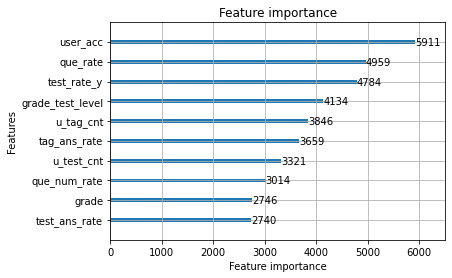

In [114]:
_ = lgb.plot_importance(model)

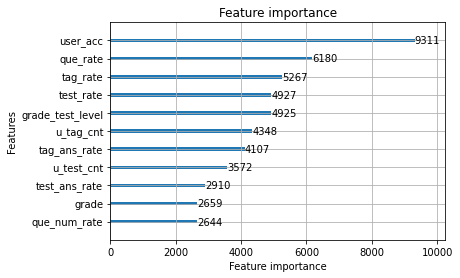

In [167]:
_ = lgb.plot_importance(model)

In [ ]:
_

In [171]:
val_preds = model.predict(test[FEATS])

In [172]:
len(val_preds)

1502

In [173]:
val_result = test
val_result['result'] = val_preds
val_result.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,result
5412,6,A030145005,A030000145,2020-10-26 09:52:14,7817,3707,408.0,920,0.443478,4,1.0,0.25,9,1.0,0.11,0.63,3,29,0.61,5,0.60,0.62,0.170246
17719,20,A030156005,A030000156,2020-10-22 07:23:06,1721,13439,421.0,717,0.587169,4,4.0,1.00,11,11.0,1.00,0.68,3,24,0.31,5,0.60,0.67,0.411960
19464,22,A070162008,A070000162,2020-12-15 00:52:18,9122,15184,407.0,605,0.672727,7,4.0,0.57,3,2.0,0.67,0.55,7,19,0.15,8,0.46,0.37,0.070875
29439,32,A070155006,A070000155,2020-12-12 09:55:59,7867,23920,422.0,932,0.452790,5,5.0,1.00,6,6.0,1.00,0.61,7,13,0.42,6,0.56,0.60,0.597963
30387,33,A070161008,A070000161,2020-12-23 04:20:28,9126,24868,545.0,947,0.575502,7,1.0,0.14,2,1.0,0.50,0.45,7,29,0.11,8,0.46,0.37,0.038128


In [53]:
y_test

5412       0
17719      1
19464      0
29439      1
30387      0
          ..
2525664    1
2525699    0
2525775    1
2525790    0
2525946    0
Name: answerCode, Length: 1502, dtype: int64

In [174]:
val_result['answer'] = y_test

In [66]:
val_result.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate_x,grade,grade_test_level,test_rate_y,que_rate,que_num,que_num_rate,tag_rate,result,answer,pred
5412,6,A030145005,A030000145,2020-10-26 09:52:14,7817,3707,408.0,920,0.443478,4,1.0,0.25,9,1.0,0.11,0.63,3,29,0.63,0.61,5,0.60,0.62,0.207780,0,0
17719,20,A030156005,A030000156,2020-10-22 07:23:06,1721,13439,421.0,717,0.587169,4,4.0,1.00,11,11.0,1.00,0.68,3,24,0.68,0.31,5,0.60,0.67,0.410603,1,0
19464,22,A070162008,A070000162,2020-12-15 00:52:18,9122,15184,407.0,605,0.672727,7,4.0,0.57,3,2.0,0.67,0.55,7,19,0.55,0.15,8,0.46,0.37,0.070822,0,0
29439,32,A070155006,A070000155,2020-12-12 09:55:59,7867,23920,422.0,932,0.452790,5,5.0,1.00,6,6.0,1.00,0.61,7,13,0.61,0.42,6,0.56,0.60,0.620531,1,1
30387,33,A070161008,A070000161,2020-12-23 04:20:28,9126,24868,545.0,947,0.575502,7,1.0,0.14,2,1.0,0.50,0.45,7,29,0.45,0.11,8,0.46,0.37,0.032842,0,0


In [175]:
def answering(val_result):
    threshold = 0.5
    if val_result['result'] >= threshold :
        return 1
    else :
        return 0

val_result['pred'] = val_result.apply(answering, axis=1)

In [176]:
val_result.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,result,answer,pred
5412,6,A030145005,A030000145,2020-10-26 09:52:14,7817,3707,408.0,920,0.443478,4,1.0,0.25,9,1.0,0.11,0.63,3,29,0.61,5,0.60,0.62,0.170246,0,0
17719,20,A030156005,A030000156,2020-10-22 07:23:06,1721,13439,421.0,717,0.587169,4,4.0,1.00,11,11.0,1.00,0.68,3,24,0.31,5,0.60,0.67,0.411960,1,0
19464,22,A070162008,A070000162,2020-12-15 00:52:18,9122,15184,407.0,605,0.672727,7,4.0,0.57,3,2.0,0.67,0.55,7,19,0.15,8,0.46,0.37,0.070875,0,0
29439,32,A070155006,A070000155,2020-12-12 09:55:59,7867,23920,422.0,932,0.452790,5,5.0,1.00,6,6.0,1.00,0.61,7,13,0.42,6,0.56,0.60,0.597963,1,1
30387,33,A070161008,A070000161,2020-12-23 04:20:28,9126,24868,545.0,947,0.575502,7,1.0,0.14,2,1.0,0.50,0.45,7,29,0.11,8,0.46,0.37,0.038128,0,0


In [177]:
# 0을 잘 맞춘 정도
TN = len(val_result[(val_result['answer'] == 0) & (val_result['pred'] == 0)])
FP = len(val_result[(val_result['answer'] == 0) & (val_result['pred'] == 1)])

# 1을 잘 맞춘 정도
FN = len(val_result[(val_result['answer'] == 1) & (val_result['pred'] == 0)])
TP = len(val_result[(val_result['answer'] == 1) & (val_result['pred'] == 1)])

print('TN(0을 0으로 맞춤) =', TN)
print('FP(0을 1으로 맞춤) =', FP)
print('FN(1을 0으로 맞춤) =', FN)
print('TP(1을 1으로 맞춤) =', TP)

Acc = (TP+TN)/(TP+TN+FP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = 2*(Recall*Precision)/(Recall+Precision)

print('Acc =', round(Acc,2))
print('Precision =', round(Precision,2))
print('Recall =', round(Recall,2))
print('F1_score =', round(F1_score,2))

TN(0을 0으로 맞춤) = 554
FP(0을 1으로 맞춤) = 221
FN(1을 0으로 맞춤) = 177
TP(1을 1으로 맞춤) = 550
Acc = 0.74
Precision = 0.71
Recall = 0.76
F1_score = 0.73


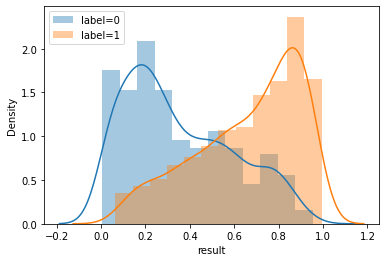

In [178]:
sns.distplot(test[test['answer']==0]['result'], label='label=0')
sns.distplot(test[test['answer']==1]['result'], label='label=1')

plt.legend()
plt.show()

In [69]:
# 0을 잘 맞춘 정도
TN = len(val_result[(val_result['answer'] == 0) & (val_result['pred'] == 0)])
FP = len(val_result[(val_result['answer'] == 0) & (val_result['pred'] == 1)])

# 1을 잘 맞춘 정도
FN = len(val_result[(val_result['answer'] == 1) & (val_result['pred'] == 0)])
TP = len(val_result[(val_result['answer'] == 1) & (val_result['pred'] == 1)])

print('TN(0을 0으로 맞춤) =', TN)
print('FP(0을 1으로 맞춤) =', FP)
print('FN(1을 0으로 맞춤) =', FN)
print('TP(1을 1으로 맞춤) =', TP)

Acc = (TP+TN)/(TP+TN+FP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = 2*(Recall*Precision)/(Recall+Precision)

print('Acc =', round(Acc,2))
print('Precision =', round(Precision,2))
print('Recall =', round(Recall,2))
print('F1_score =', round(F1_score,2))

TN(0을 0으로 맞춤) = 555
FP(0을 1으로 맞춤) = 220
FN(1을 0으로 맞춤) = 186
TP(1을 1으로 맞춤) = 541
Acc = 0.73
Precision = 0.71
Recall = 0.74
F1_score = 0.73


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


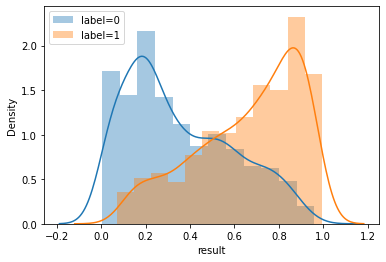

In [72]:
sns.distplot(test[test['answer']==0]['result'], label='label=0')
sns.distplot(test[test['answer']==1]['result'], label='label=1')

plt.legend()
plt.show()

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

train_X = torch.rand(10, 2)
Y = 1 - torch.norm(train_X - 0.5, dim=-1, keepdim=True)
Y = Y + 0.1 * torch.randn_like(Y)  # add some noise
train_Y = standardize(Y)

gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

In [ ]:
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

In [ ]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)])
candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate  # tensor([0.4887, 0.5063])

In [80]:
# 모델과 관련없는 변수 고정
func_fixed = partial(model, x_data=lgb_train, y_data=lgb_test, output='answerCode') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (16, 1024),      # n_estimators,     범위(16~1024)
        'subsample': (0, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0, 1),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0, 10),            # reg_alpha,        범위(0~10)
        'reg_lambda': (0, 50),           # reg_lambda,       범위(0~50)
    }, 
    random_state=4321                    # 시드 고정
)
lgbBO.maximize(init_points=5, n_iter=30)

TypeError: the first argument must be callable

In [103]:
# 모연 코드 참고
def lgb_eval(max_depth,num_leaves,colsample_bytree,subsample):
    lgb_train = lgb.Dataset(train[FEATS], y_train)
    lgb_test = lgb.Dataset(test[FEATS], y_test)
    params = {
        'objective': 'binary', # 이진 분류
        'metric':'auc',
        'max_depth' : int(max_depth),
        'num_leaves': int(num_leaves),
        'colsample_bytree' : colsample_bytree,
        'subsample' : subsample,
#         'n_estimators' : int(n_estimators),
        'early_stopping_rounds': 100,
        'learning_rate' : 0.0001
    }
#     lgbm_train = lgb.DMatrix(np.array(train2),train["y"]) # train칼럼명 겹칠수 있어서 np.array로 묶음
    clf = lgb.train(params, lgb_train,
                valid_sets=[lgb_train, lgb_test], # Validation 성능을 측정할 수 있도록 설정
                categorical_feature='auto',
                verbose_eval=100,    
                num_boost_round=5000,
                
#                 xgb_train, #교차검증 점수 이렇게 바로 가져올 수 있음(파이썬 레퍼)
#                 num_boost_round=5000, #num_boost_round는 어차피 하다가 멈추니까 엄청 높게 하는게 좋음. 여기선 시간관계상
#                 early_stopping_rounds=10,
#                 nfold=4             
                )
    val_preds = clf.predict(test[FEATS])
#     acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_test, val_preds)
    
    return auc

In [104]:
lgb_opt = BayesianOptimization(lgb_eval,{"max_depth":(3,15),
                                         "num_leaves": (2, 256),
                                        "colsample_bytree":(0.5,1),
                                        "subsample":(0.5,1)
#                                         "n_estimators":(60,200)})
                                         })
lgb_opt.maximize(n_iter=20,init_points=3)

|   iter    |  target   | colsam... | max_depth | num_le... | subsample |
-------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 1322516, number of negative: 697519
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 2020035, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654700 -> initscore=0.639762
[LightGBM] [Info] Start training from score 0.639762
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.798961	valid_1's auc: 0.772207
[200]	training's auc: 0.799304	valid_1's auc: 0.773184
[300]	training's auc: 0.799397	valid_1's auc: 0.773045
Early stopping, best iteration is:
[280]	training's auc: 0.799

In [227]:
# 유저별 분리 - kfold 에서 0번 fold의 dataset을 가져옴
# train_set , val_set

# 사용할 Feature 설정    user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
FEATS = ['user_acc','u_test_cnt','test_ans_rate','u_tag_cnt','tag_ans_rate','test_rate','grade','grade_test_level','que_rate','que_num_rate','tag_rate']
# FEATS = ['user_acc','u_test_cnt','test_ans_rate', 'u_tag_cnt','tag_ans_rate', 'que_num_rate', 'test_rate_y','grade','grade_test_level', 'que_rate']
# FEATS = ['user_acc','que_num_rate', 'test_rate', 'que_rate', 'user_total_answer_test', 'user_correct_answer_test',  'user_acc_test', 'user_total_answer_tag', 'user_acc_tag']
# drop features : 'KnowledgeTag','test_mean', 'test_sum', 'user_total_answer', 'user_correct_answer','tag_mean','tag_sum','test_ans_cnt',  'ans_cnt',  'user_correct_answer_tag',

# X, y 값 분리
y_train = train_set['answerCode']
train = train_set.drop(['answerCode'], axis=1)

y_test = val_set['answerCode']
test = val_set.drop(['answerCode'], axis=1)

In [228]:
import optuna

def objective(trial):
    lgb_train = lgb.Dataset(train[FEATS], y_train)
    lgb_test = lgb.Dataset(test[FEATS], y_test)
    model_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'metric':'auc',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
#         'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'n_estimators': 100, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': 37,
        'verbose': -1,
        'n_jobs': -1,    
    }
    clf = lgb.train(
                model_params,
                lgb_train,
                valid_sets=[lgb_train, lgb_test], # Validation 성능을 측정할 수 있도록 설정
                categorical_feature='auto',
                verbose_eval=100,    
                num_boost_round=5000,
            )
            
    val_preds = clf.predict(test[FEATS])
#     acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_test, val_preds)
    return auc
    

In [229]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) #n_trial 몇번 할지

[I 2021-06-11 05:31:05,082] A new study created in memory with name: no-name-9142e4f9-f875-4a2f-8851-eaa4a8e670de


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.833989	valid_1's auc: 0.810263
[200]	training's auc: 0.836695	valid_1's auc: 0.811192


[I 2021-06-11 05:32:10,021] Trial 0 finished with value: 0.8115105973717799 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 11, 'feature_fraction': 0.8924593706911026, 'bagging_fraction': 0.7244179229900176, 'bagging_freq': 2}. Best is trial 0 with value: 0.8115105973717799.


Early stopping, best iteration is:
[138]	training's auc: 0.835077	valid_1's auc: 0.811511
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.832249	valid_1's auc: 0.811181
[200]	training's auc: 0.834532	valid_1's auc: 0.812363
[300]	training's auc: 0.836055	valid_1's auc: 0.813306


[I 2021-06-11 05:33:47,595] Trial 1 finished with value: 0.813626476351412 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 30, 'feature_fraction': 0.45298244944651866, 'bagging_fraction': 0.5169368716131405, 'bagging_freq': 3}. Best is trial 1 with value: 0.813626476351412.


Early stopping, best iteration is:
[264]	training's auc: 0.835538	valid_1's auc: 0.813626
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.832406	valid_1's auc: 0.811529
[200]	training's auc: 0.834111	valid_1's auc: 0.81235
[300]	training's auc: 0.835521	valid_1's auc: 0.812652
[400]	training's auc: 0.836757	valid_1's auc: 0.81269


[I 2021-06-11 05:35:45,396] Trial 2 finished with value: 0.8131590774264297 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 20, 'feature_fraction': 0.6819812390379778, 'bagging_fraction': 0.9590243417485231, 'bagging_freq': 4}. Best is trial 1 with value: 0.813626476351412.


Early stopping, best iteration is:
[351]	training's auc: 0.83616	valid_1's auc: 0.813159
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.83138	valid_1's auc: 0.810628
[200]	training's auc: 0.832702	valid_1's auc: 0.81212
[300]	training's auc: 0.833721	valid_1's auc: 0.812585
[400]	training's auc: 0.834625	valid_1's auc: 0.812774


[I 2021-06-11 05:37:47,821] Trial 3 finished with value: 0.8128247074262499 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 25, 'feature_fraction': 0.7947314462152395, 'bagging_fraction': 0.6131116011794779, 'bagging_freq': 2}. Best is trial 1 with value: 0.813626476351412.


Early stopping, best iteration is:
[391]	training's auc: 0.834548	valid_1's auc: 0.812825
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.830503	valid_1's auc: 0.810087
[200]	training's auc: 0.831869	valid_1's auc: 0.810468
[300]	training's auc: 0.83279	valid_1's auc: 0.811276


[I 2021-06-11 05:39:27,065] Trial 4 finished with value: 0.811275999065202 and parameters: {'num_leaves': 33, 'min_data_in_leaf': 14, 'feature_fraction': 0.5159313507185155, 'bagging_fraction': 0.45710267444502595, 'bagging_freq': 5}. Best is trial 1 with value: 0.813626476351412.


[400]	training's auc: 0.833497	valid_1's auc: 0.810383
Early stopping, best iteration is:
[300]	training's auc: 0.83279	valid_1's auc: 0.811276
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.832521	valid_1's auc: 0.810648
[200]	training's auc: 0.834917	valid_1's auc: 0.812012
[300]	training's auc: 0.836478	valid_1's auc: 0.812382
[400]	training's auc: 0.837876	valid_1's auc: 0.812672


[I 2021-06-11 05:41:19,752] Trial 5 finished with value: 0.8127312276412533 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 33, 'feature_fraction': 0.4624346475675133, 'bagging_fraction': 0.882874620739682, 'bagging_freq': 5}. Best is trial 1 with value: 0.813626476351412.


Early stopping, best iteration is:
[326]	training's auc: 0.836854	valid_1's auc: 0.812731
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836634	valid_1's auc: 0.81167
[200]	training's auc: 0.840998	valid_1's auc: 0.813471
[300]	training's auc: 0.844578	valid_1's auc: 0.812692


[I 2021-06-11 05:42:50,508] Trial 6 finished with value: 0.8138386035558272 and parameters: {'num_leaves': 250, 'min_data_in_leaf': 40, 'feature_fraction': 0.7251574035935987, 'bagging_fraction': 0.5770376940945225, 'bagging_freq': 5}. Best is trial 6 with value: 0.8138386035558272.


Early stopping, best iteration is:
[223]	training's auc: 0.8419	valid_1's auc: 0.813839
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835396	valid_1's auc: 0.812568
[200]	training's auc: 0.838493	valid_1's auc: 0.812783
[300]	training's auc: 0.841179	valid_1's auc: 0.812915


[I 2021-06-11 05:44:29,303] Trial 7 finished with value: 0.8130413288510976 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 22, 'feature_fraction': 0.750513282525757, 'bagging_fraction': 0.9907099804184876, 'bagging_freq': 3}. Best is trial 6 with value: 0.8138386035558272.


Early stopping, best iteration is:
[240]	training's auc: 0.839573	valid_1's auc: 0.813041
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834624	valid_1's auc: 0.81232
[200]	training's auc: 0.837783	valid_1's auc: 0.812956


[I 2021-06-11 05:45:42,076] Trial 8 finished with value: 0.8130961583403743 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 20, 'feature_fraction': 0.7666971977152954, 'bagging_fraction': 0.5076337761406059, 'bagging_freq': 1}. Best is trial 6 with value: 0.8138386035558272.


Early stopping, best iteration is:
[158]	training's auc: 0.836549	valid_1's auc: 0.813096
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834793	valid_1's auc: 0.812299


[I 2021-06-11 05:46:38,724] Trial 9 finished with value: 0.8125271900336167 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 33, 'feature_fraction': 0.8394103314044106, 'bagging_fraction': 0.5266663238326474, 'bagging_freq': 4}. Best is trial 6 with value: 0.8138386035558272.


Early stopping, best iteration is:
[92]	training's auc: 0.834456	valid_1's auc: 0.812527
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.837155	valid_1's auc: 0.811039
[200]	training's auc: 0.841487	valid_1's auc: 0.811396


[I 2021-06-11 05:47:38,793] Trial 10 finished with value: 0.8121209125065165 and parameters: {'num_leaves': 251, 'min_data_in_leaf': 39, 'feature_fraction': 0.9883352816099553, 'bagging_fraction': 0.7490787509184944, 'bagging_freq': 7}. Best is trial 6 with value: 0.8138386035558272.


Early stopping, best iteration is:
[121]	training's auc: 0.838202	valid_1's auc: 0.812121
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836438	valid_1's auc: 0.811925
[200]	training's auc: 0.840573	valid_1's auc: 0.812916
[300]	training's auc: 0.844175	valid_1's auc: 0.813916
[400]	training's auc: 0.847206	valid_1's auc: 0.814255
[500]	training's auc: 0.850177	valid_1's auc: 0.813925
Early stopping, best iteration is:
[404]	training's auc: 0.847333	valid_1's auc: 0.814352


[I 2021-06-11 05:49:59,665] Trial 11 finished with value: 0.8143518435292214 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 40, 'feature_fraction': 0.607655005391353, 'bagging_fraction': 0.5975442822622602, 'bagging_freq': 7}. Best is trial 11 with value: 0.8143518435292214.


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836478	valid_1's auc: 0.812804
[200]	training's auc: 0.840632	valid_1's auc: 0.814132
[300]	training's auc: 0.844093	valid_1's auc: 0.813155


[I 2021-06-11 05:51:28,834] Trial 12 finished with value: 0.8145774533949341 and parameters: {'num_leaves': 254, 'min_data_in_leaf': 40, 'feature_fraction': 0.6094518259127273, 'bagging_fraction': 0.6239191335550087, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[212]	training's auc: 0.841052	valid_1's auc: 0.814577
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835225	valid_1's auc: 0.811291
[200]	training's auc: 0.838887	valid_1's auc: 0.811745
[300]	training's auc: 0.841765	valid_1's auc: 0.811305


[I 2021-06-11 05:52:54,973] Trial 13 finished with value: 0.8122072015388211 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 40, 'feature_fraction': 0.5817402865120541, 'bagging_fraction': 0.6557252202878451, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[206]	training's auc: 0.839052	valid_1's auc: 0.812207
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835514	valid_1's auc: 0.813556
[200]	training's auc: 0.839279	valid_1's auc: 0.812729


[I 2021-06-11 05:53:59,375] Trial 14 finished with value: 0.8140237654376472 and parameters: {'num_leaves': 220, 'min_data_in_leaf': 36, 'feature_fraction': 0.6158529984249278, 'bagging_fraction': 0.4080482397070927, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[130]	training's auc: 0.836781	valid_1's auc: 0.814024
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835967	valid_1's auc: 0.812998
[200]	training's auc: 0.839811	valid_1's auc: 0.813518


[I 2021-06-11 05:55:08,228] Trial 15 finished with value: 0.813763100652561 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 28, 'feature_fraction': 0.6295425685994371, 'bagging_fraction': 0.7865835863345749, 'bagging_freq': 6}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[138]	training's auc: 0.837592	valid_1's auc: 0.813763
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836084	valid_1's auc: 0.812072
[200]	training's auc: 0.840237	valid_1's auc: 0.811804
[300]	training's auc: 0.843527	valid_1's auc: 0.811563
[400]	training's auc: 0.846413	valid_1's auc: 0.812275
Early stopping, best iteration is:
[371]	training's auc: 0.845621	valid_1's auc: 0.813348


[I 2021-06-11 05:57:18,298] Trial 16 finished with value: 0.8133478346845956 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 36, 'feature_fraction': 0.550226865171907, 'bagging_fraction': 0.6676565596560565, 'bagging_freq': 6}. Best is trial 12 with value: 0.8145774533949341.


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.83543	valid_1's auc: 0.812378
[200]	training's auc: 0.838903	valid_1's auc: 0.812772
[300]	training's auc: 0.841688	valid_1's auc: 0.812995


[I 2021-06-11 05:58:45,585] Trial 17 finished with value: 0.8131384040124401 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 36, 'feature_fraction': 0.6652307518781205, 'bagging_fraction': 0.8087004657762897, 'bagging_freq': 6}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[206]	training's auc: 0.83911	valid_1's auc: 0.813138
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.831835	valid_1's auc: 0.806331
[200]	training's auc: 0.836593	valid_1's auc: 0.808413
[300]	training's auc: 0.839039	valid_1's auc: 0.809441


[I 2021-06-11 06:00:35,278] Trial 18 finished with value: 0.809840545059054 and parameters: {'num_leaves': 239, 'min_data_in_leaf': 40, 'feature_fraction': 0.4089783885408522, 'bagging_fraction': 0.6139079294339684, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[283]	training's auc: 0.838683	valid_1's auc: 0.809841
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834473	valid_1's auc: 0.809554
[200]	training's auc: 0.837553	valid_1's auc: 0.811122


[I 2021-06-11 06:01:50,341] Trial 19 finished with value: 0.81132543548996 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 33, 'feature_fraction': 0.5112202778373596, 'bagging_fraction': 0.42218384991553676, 'bagging_freq': 6}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[184]	training's auc: 0.837135	valid_1's auc: 0.811325
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835417	valid_1's auc: 0.810097
[200]	training's auc: 0.839219	valid_1's auc: 0.809625


[I 2021-06-11 06:02:50,231] Trial 20 finished with value: 0.8104634440110019 and parameters: {'num_leaves': 226, 'min_data_in_leaf': 37, 'feature_fraction': 0.57580025609861, 'bagging_fraction': 0.5739914204906399, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[105]	training's auc: 0.835648	valid_1's auc: 0.810463
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835236	valid_1's auc: 0.811423
[200]	training's auc: 0.838741	valid_1's auc: 0.812178


[I 2021-06-11 06:03:56,878] Trial 21 finished with value: 0.8129891958940803 and parameters: {'num_leaves': 203, 'min_data_in_leaf': 37, 'feature_fraction': 0.6372434494149245, 'bagging_fraction': 0.4388434513844108, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[125]	training's auc: 0.836233	valid_1's auc: 0.812989
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836622	valid_1's auc: 0.812815
[200]	training's auc: 0.840954	valid_1's auc: 0.813277


[I 2021-06-11 06:05:20,586] Trial 22 finished with value: 0.8135320977223289 and parameters: {'num_leaves': 254, 'min_data_in_leaf': 30, 'feature_fraction': 0.6148121883654118, 'bagging_fraction': 0.6887615548237914, 'bagging_freq': 6}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[184]	training's auc: 0.840327	valid_1's auc: 0.813532
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836214	valid_1's auc: 0.81162
[200]	training's auc: 0.840226	valid_1's auc: 0.81168


[I 2021-06-11 06:06:24,524] Trial 23 finished with value: 0.8131446959210455 and parameters: {'num_leaves': 231, 'min_data_in_leaf': 40, 'feature_fraction': 0.6993141534159211, 'bagging_fraction': 0.4927459050888931, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[128]	training's auc: 0.837436	valid_1's auc: 0.813145
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.823491	valid_1's auc: 0.801032
[200]	training's auc: 0.826785	valid_1's auc: 0.80612
[300]	training's auc: 0.827826	valid_1's auc: 0.807824
[400]	training's auc: 0.828575	valid_1's auc: 0.808435
[500]	training's auc: 0.829052	valid_1's auc: 0.809025
[600]	training's auc: 0.829454	valid_1's auc: 0.809534
[700]	training's auc: 0.829716	valid_1's auc: 0.809939
[800]	training's auc: 0.82991	valid_1's auc: 0.810198
[900]	training's auc: 0.830078	valid_1's auc: 0.810297
[1000]	training's auc: 0.830217	valid_1's auc: 0.810295
[1100]	training's auc: 0.830334	valid_1's auc: 0.810196


[I 2021-06-11 06:10:31,695] Trial 24 finished with value: 0.8104517590378774 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 35, 'feature_fraction': 0.5369748324333309, 'bagging_fraction': 0.562400460934267, 'bagging_freq': 6}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[1007]	training's auc: 0.830222	valid_1's auc: 0.810452
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834502	valid_1's auc: 0.811249
[200]	training's auc: 0.837552	valid_1's auc: 0.810637


[I 2021-06-11 06:11:32,347] Trial 25 finished with value: 0.8117973286353749 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 38, 'feature_fraction': 0.6098625146898504, 'bagging_fraction': 0.627160657711759, 'bagging_freq': 5}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[118]	training's auc: 0.835133	valid_1's auc: 0.811797
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835806	valid_1's auc: 0.811702
[200]	training's auc: 0.839838	valid_1's auc: 0.811922


[I 2021-06-11 06:12:54,268] Trial 26 finished with value: 0.8122710194689629 and parameters: {'num_leaves': 237, 'min_data_in_leaf': 34, 'feature_fraction': 0.5034282016735621, 'bagging_fraction': 0.8470626253392997, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[173]	training's auc: 0.838914	valid_1's auc: 0.812271
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834951	valid_1's auc: 0.812064
[200]	training's auc: 0.838262	valid_1's auc: 0.811851


[I 2021-06-11 06:14:05,198] Trial 27 finished with value: 0.8130934618081147 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 29, 'feature_fraction': 0.6594353756456024, 'bagging_fraction': 0.4092177068990772, 'bagging_freq': 6}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[137]	training's auc: 0.836317	valid_1's auc: 0.813093
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835149	valid_1's auc: 0.811094
[200]	training's auc: 0.838775	valid_1's auc: 0.811006


[I 2021-06-11 06:15:07,387] Trial 28 finished with value: 0.8113425135276034 and parameters: {'num_leaves': 216, 'min_data_in_leaf': 31, 'feature_fraction': 0.5828365321994644, 'bagging_fraction': 0.47829500336173647, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[120]	training's auc: 0.835981	valid_1's auc: 0.811343
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834342	valid_1's auc: 0.812142
[200]	training's auc: 0.837212	valid_1's auc: 0.8115


[I 2021-06-11 06:16:11,696] Trial 29 finished with value: 0.8125361784744818 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 27, 'feature_fraction': 0.7147425665738372, 'bagging_fraction': 0.7254843078719526, 'bagging_freq': 5}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[120]	training's auc: 0.834992	valid_1's auc: 0.812536
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836935	valid_1's auc: 0.811616
[200]	training's auc: 0.841499	valid_1's auc: 0.812836
[300]	training's auc: 0.845307	valid_1's auc: 0.81188


[I 2021-06-11 06:17:41,075] Trial 30 finished with value: 0.8129136929908137 and parameters: {'num_leaves': 241, 'min_data_in_leaf': 10, 'feature_fraction': 0.824470201337267, 'bagging_fraction': 0.7175974085800175, 'bagging_freq': 7}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[219]	training's auc: 0.842215	valid_1's auc: 0.812914
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836732	valid_1's auc: 0.811769


[I 2021-06-11 06:18:35,544] Trial 31 finished with value: 0.8122296726409837 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 40, 'feature_fraction': 0.7252079189495231, 'bagging_fraction': 0.5577440956289252, 'bagging_freq': 5}. Best is trial 12 with value: 0.8145774533949341.


Early stopping, best iteration is:
[76]	training's auc: 0.835434	valid_1's auc: 0.81223
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836478	valid_1's auc: 0.812907
[200]	training's auc: 0.840729	valid_1's auc: 0.812694
[300]	training's auc: 0.844204	valid_1's auc: 0.814168
[400]	training's auc: 0.847406	valid_1's auc: 0.813908
Early stopping, best iteration is:
[311]	training's auc: 0.844571	valid_1's auc: 0.815001


[I 2021-06-11 06:20:33,797] Trial 32 finished with value: 0.8150008089596779 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 38, 'feature_fraction': 0.6623969601759928, 'bagging_fraction': 0.5877385312344033, 'bagging_freq': 6}. Best is trial 32 with value: 0.8150008089596779.


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836601	valid_1's auc: 0.812659
[200]	training's auc: 0.840728	valid_1's auc: 0.812631


[I 2021-06-11 06:21:50,171] Trial 33 finished with value: 0.8132930051953187 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 38, 'feature_fraction': 0.6659306108454547, 'bagging_fraction': 0.6414005957542344, 'bagging_freq': 6}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[158]	training's auc: 0.839148	valid_1's auc: 0.813293
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.83528	valid_1's auc: 0.811438
[200]	training's auc: 0.839064	valid_1's auc: 0.811081


[I 2021-06-11 06:22:52,390] Trial 34 finished with value: 0.8116427274524962 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 38, 'feature_fraction': 0.5638569759684127, 'bagging_fraction': 0.5328279521058717, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[107]	training's auc: 0.835629	valid_1's auc: 0.811643
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835502	valid_1's auc: 0.812584


[I 2021-06-11 06:23:49,016] Trial 35 finished with value: 0.8126323547917378 and parameters: {'num_leaves': 203, 'min_data_in_leaf': 36, 'feature_fraction': 0.6141116012643334, 'bagging_fraction': 0.5980045425864924, 'bagging_freq': 6}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[96]	training's auc: 0.835339	valid_1's auc: 0.812632
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836652	valid_1's auc: 0.810504
[200]	training's auc: 0.840912	valid_1's auc: 0.810107


[I 2021-06-11 06:24:56,651] Trial 36 finished with value: 0.8108652273176694 and parameters: {'num_leaves': 238, 'min_data_in_leaf': 16, 'feature_fraction': 0.6836113844502619, 'bagging_fraction': 0.6770325696634546, 'bagging_freq': 3}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[132]	training's auc: 0.837998	valid_1's auc: 0.810865
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.832195	valid_1's auc: 0.810564
[200]	training's auc: 0.834441	valid_1's auc: 0.811379


[I 2021-06-11 06:25:59,477] Trial 37 finished with value: 0.8114665540115411 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 32, 'feature_fraction': 0.45572973661578486, 'bagging_fraction': 0.592509131634078, 'bagging_freq': 4}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[136]	training's auc: 0.833159	valid_1's auc: 0.811467
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835476	valid_1's auc: 0.812293
[200]	training's auc: 0.839151	valid_1's auc: 0.813716
[300]	training's auc: 0.842201	valid_1's auc: 0.813542


[I 2021-06-11 06:27:21,624] Trial 38 finished with value: 0.8138907365128445 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 34, 'feature_fraction': 0.6492556454664661, 'bagging_fraction': 0.5472137161150497, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[203]	training's auc: 0.839223	valid_1's auc: 0.813891
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.833765	valid_1's auc: 0.810862
[200]	training's auc: 0.836282	valid_1's auc: 0.811773
[300]	training's auc: 0.838371	valid_1's auc: 0.811646


[I 2021-06-11 06:28:44,529] Trial 39 finished with value: 0.8121254067269491 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 24, 'feature_fraction': 0.7673793338818163, 'bagging_fraction': 0.4634009266205389, 'bagging_freq': 6}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[204]	training's auc: 0.836367	valid_1's auc: 0.812125
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834962	valid_1's auc: 0.810673
[200]	training's auc: 0.83821	valid_1's auc: 0.811572
[300]	training's auc: 0.840738	valid_1's auc: 0.811263


[I 2021-06-11 06:30:13,431] Trial 40 finished with value: 0.8120678807054129 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 39, 'feature_fraction': 0.5964073216812504, 'bagging_fraction': 0.7587300581177399, 'bagging_freq': 2}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[224]	training's auc: 0.838844	valid_1's auc: 0.812068
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835485	valid_1's auc: 0.81275
[200]	training's auc: 0.839135	valid_1's auc: 0.813449
[300]	training's auc: 0.842056	valid_1's auc: 0.813164


[I 2021-06-11 06:31:45,203] Trial 41 finished with value: 0.8140974706527406 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 35, 'feature_fraction': 0.6376725543836639, 'bagging_fraction': 0.5433911223480077, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[245]	training's auc: 0.840424	valid_1's auc: 0.814097
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835835	valid_1's auc: 0.810909
[200]	training's auc: 0.839736	valid_1's auc: 0.81138
[300]	training's auc: 0.84302	valid_1's auc: 0.811886
[400]	training's auc: 0.845905	valid_1's auc: 0.811897


[I 2021-06-11 06:33:38,103] Trial 42 finished with value: 0.8124346090927068 and parameters: {'num_leaves': 245, 'min_data_in_leaf': 35, 'feature_fraction': 0.5341143393153753, 'bagging_fraction': 0.626351948683373, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[307]	training's auc: 0.843232	valid_1's auc: 0.812435
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834829	valid_1's auc: 0.810735
[200]	training's auc: 0.838515	valid_1's auc: 0.812817
[300]	training's auc: 0.841274	valid_1's auc: 0.813399
[400]	training's auc: 0.843668	valid_1's auc: 0.812936
Early stopping, best iteration is:
[354]	training's auc: 0.842596	valid_1's auc: 0.813614


[I 2021-06-11 06:35:38,824] Trial 43 finished with value: 0.813613892534201 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 38, 'feature_fraction': 0.4837310770220787, 'bagging_fraction': 0.5192872696331352, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835542	valid_1's auc: 0.811966
[200]	training's auc: 0.839025	valid_1's auc: 0.813292
[300]	training's auc: 0.842008	valid_1's auc: 0.813463


[I 2021-06-11 06:37:01,665] Trial 44 finished with value: 0.8137136642278031 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 40, 'feature_fraction': 0.6949818556785177, 'bagging_fraction': 0.5941545630602523, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[215]	training's auc: 0.839436	valid_1's auc: 0.813714
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835682	valid_1's auc: 0.812066
[200]	training's auc: 0.83945	valid_1's auc: 0.812686


[I 2021-06-11 06:38:16,197] Trial 45 finished with value: 0.8134071583943049 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 35, 'feature_fraction': 0.6365821833281493, 'bagging_fraction': 0.49472697241136715, 'bagging_freq': 6}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[180]	training's auc: 0.838793	valid_1's auc: 0.813407
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.836062	valid_1's auc: 0.81263
[200]	training's auc: 0.840177	valid_1's auc: 0.813957
[300]	training's auc: 0.843472	valid_1's auc: 0.813498


[I 2021-06-11 06:39:51,243] Trial 46 finished with value: 0.8145091412443597 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 37, 'feature_fraction': 0.5552121814625505, 'bagging_fraction': 0.6513054138290423, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[247]	training's auc: 0.841691	valid_1's auc: 0.814509
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835472	valid_1's auc: 0.810439
[200]	training's auc: 0.839523	valid_1's auc: 0.811572
[300]	training's auc: 0.842641	valid_1's auc: 0.8117


[I 2021-06-11 06:41:30,541] Trial 47 finished with value: 0.8121209125065165 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 39, 'feature_fraction': 0.4229836523065682, 'bagging_fraction': 0.6496491584659498, 'bagging_freq': 7}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[265]	training's auc: 0.841603	valid_1's auc: 0.812121
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835957	valid_1's auc: 0.811494
[200]	training's auc: 0.840004	valid_1's auc: 0.811592


[I 2021-06-11 06:42:35,059] Trial 48 finished with value: 0.8121955165656966 and parameters: {'num_leaves': 247, 'min_data_in_leaf': 37, 'feature_fraction': 0.5522300699894941, 'bagging_fraction': 0.7167944612177338, 'bagging_freq': 5}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[131]	training's auc: 0.837423	valid_1's auc: 0.812196
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.831405	valid_1's auc: 0.811036
[200]	training's auc: 0.832826	valid_1's auc: 0.812274
[300]	training's auc: 0.8338	valid_1's auc: 0.812482


[I 2021-06-11 06:44:08,287] Trial 49 finished with value: 0.8128669530983155 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 33, 'feature_fraction': 0.7320590559931422, 'bagging_fraction': 0.6940978562562355, 'bagging_freq': 6}. Best is trial 32 with value: 0.8150008089596779.


Early stopping, best iteration is:
[261]	training's auc: 0.833438	valid_1's auc: 0.812867


In [109]:
study.best_params

{'num_leaves': 107,
 'max_bin': 204,
 'min_data_in_leaf': 20,
 'feature_fraction': 0.46948747908887395,
 'bagging_fraction': 0.9028430805809137,
 'bagging_freq': 1,
 'lambda_l1': 0.00010175824628083187,
 'lambda_l2': 0.0001150682989588032}

In [ ]:
# test dataset EDA

In [185]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,260112,10.0,14,0.714286,3,2.0,0.67,1,1.0,1.0,0.64,4,30,0.83,4,0.66,0.77


In [192]:
test_df.groupby(['userID')['grade'].unique().reset_index(name='grade')

,userID,grade
0,3,"[5, 2]"
1,4,"[4, 7, 1]"
2,13,"[6, 2, 7]"
3,17,"[4, 9, 2]"
4,26,"[6, 2]"
...,...,...
739,7395,"[3, 7, 4]"
740,7404,"[2, 4, 3]"
741,7416,"[8, 3, 5]"
742,7417,"[1, 5]"


In [196]:
test_grade = test_df.groupby(['userID','grade'])['grade'].count().reset_index(name='grade_cnt')

In [198]:
test_grade[:3]

,userID,grade,grade_cnt
0,3,2,174
1,3,5,862
2,4,1,129


In [200]:
grade_df = test_grade.groupby(['userID'], as_index=False).max()  # 가장 많은 cnt개수 
grade_df

,userID,grade,grade_cnt
0,3,5,862
1,4,7,426
2,13,7,603
3,17,9,529
4,26,6,335
...,...,...,...
739,7395,7,10
740,7404,4,5
741,7416,8,6
742,7417,5,11


In [241]:
# grade_df.to_csv('test_grade.csv')

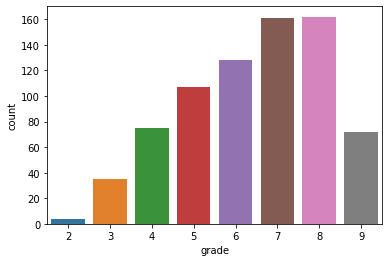

In [205]:
sns.countplot(grade_df['grade'])
plt.show()

In [211]:
for i in range(1,10):
    count = len(grade_df[grade_df['grade']==i])
    dense = round(count/744, 2)
    print(f'grade={i} : count = ', count, '/ dense =', dense )

grade=1 : count =  0 / dense = 0.0
grade=2 : count =  4 / dense = 0.01
grade=3 : count =  35 / dense = 0.05
grade=4 : count =  75 / dense = 0.1
grade=5 : count =  107 / dense = 0.14
grade=6 : count =  128 / dense = 0.17
grade=7 : count =  161 / dense = 0.22
grade=8 : count =  162 / dense = 0.22
grade=9 : count =  72 / dense = 0.1


In [213]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.5,0,0.0,0.5,0.95,6,1,0.98,1,0.75,0.96
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.0,1,1.0,1.0,0,0.0,0.5,0.95,6,1,0.97,2,0.72,0.92
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.0,2,2.0,1.0,1,1.0,1.0,0.95,6,1,0.92,3,0.69,0.92
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.0,3,3.0,1.0,2,2.0,1.0,0.95,6,1,0.97,4,0.66,0.92
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.0,4,4.0,1.0,3,3.0,1.0,0.95,6,1,0.95,5,0.60,0.92


In [215]:
df_train_grade = df.groupby(['userID','grade'])['grade'].count().reset_index(name='grade_cnt')
train_grade_last = df_train_grade.groupby(['userID'], as_index=False).max()  # 가장 많은 cnt개수 
train_grade_last

,userID,grade,grade_cnt
0,0,8,363
1,1,9,581
2,2,5,178
3,3,5,861
4,4,7,425
...,...,...,...
7437,7437,6,10
7438,7438,8,6
7439,7439,4,15
7440,7440,5,10


In [240]:
# train_grade_last.to_csv('train_test_grade.csv')

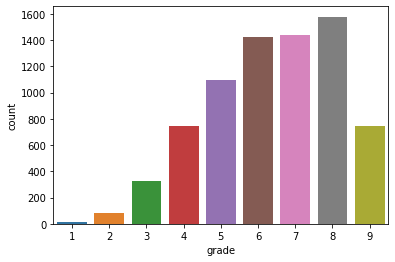

In [216]:
sns.countplot(train_grade_last['grade'])
plt.show()

In [238]:
for i in range(1,10):
    count = len(train_grade_last[train_grade_last['grade']==i])
    dense = round(count/7442 , 2)
    print(f'grade={i} : count = ', count, '/ dense =', dense )

grade=1 : count =  12 / dense = 0.0
grade=2 : count =  81 / dense = 0.01
grade=3 : count =  323 / dense = 0.04
grade=4 : count =  748 / dense = 0.1
grade=5 : count =  1097 / dense = 0.15
grade=6 : count =  1424 / dense = 0.19
grade=7 : count =  1436 / dense = 0.19
grade=8 : count =  1578 / dense = 0.21
grade=9 : count =  743 / dense = 0.1


In [228]:
only_train = train.copy()

In [230]:
only_train = only_train.merge(grade_test_level, on='testId', how='left')
only_train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,NaN,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29


In [231]:
only_train['grade'] = only_train['grade'].astype(int)
only_train['user_correct_answer'] = only_train['user_correct_answer'].fillna(0)

# test_rate
# all_test_rate = test_rate(df)
# train = pd.merge(train, all_test_rate, on='testId', how='left')

# que_rate
# all_que_rate = que_rate(df)
only_train = pd.merge(only_train, all_que_rate, on='assessmentItemID', how='left')

# que_num_rate
only_train['que_num'] = only_train['assessmentItemID'].str.slice(start=7, stop=10)
only_train['que_num'] = only_train['que_num'].astype(int)
# que_num_df = que_num_rate(df)
only_train = only_train.merge(que_num_df, on='que_num', how='left')

# tag_rate
# all_tag_rate = tag_rate(df)
only_train = pd.merge(only_train, all_tag_rate, on='KnowledgeTag', how='left')

In [232]:
only_train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29,0.79,3,0.69,0.70


In [233]:
only_train_grade = only_train.groupby(['userID','grade'])['grade'].count().reset_index(name='grade_cnt')
only_train_grade_max = only_train_grade.groupby(['userID'], as_index=False).max()  # 가장 많은 cnt개수 
only_train_grade_max

,userID,grade,grade_cnt
0,0,8,363
1,1,9,581
2,2,5,178
3,5,8,613
4,6,4,615
...,...,...,...
6693,7436,5,11
6694,7437,6,10
6695,7438,8,6
6696,7440,5,10


In [242]:
# only_train_grade_max.to_csv('train_grade.csv')

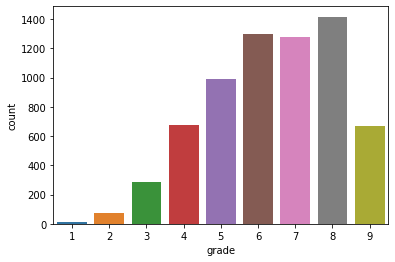

In [236]:
sns.countplot(only_train_grade_max['grade'])
plt.show()

In [239]:
for i in range(1,10):
    count = len(only_train_grade_max[only_train_grade_max['grade']==i])
    dense = round(count/6698 , 2)
    print(f'grade={i} : count = ', count, '/ dense =', dense )

grade=1 : count =  12 / dense = 0.0
grade=2 : count =  77 / dense = 0.01
grade=3 : count =  288 / dense = 0.04
grade=4 : count =  673 / dense = 0.1
grade=5 : count =  990 / dense = 0.15
grade=6 : count =  1296 / dense = 0.19
grade=7 : count =  1275 / dense = 0.19
grade=8 : count =  1416 / dense = 0.21
grade=9 : count =  671 / dense = 0.1


In [260]:
cnt = 0
test_list = []
train_test_list = []
for id in grade_df['userID']:
    test_g = int(grade_df[grade_df['userID']==id]['grade'])
    train_test_g = int(train_grade_last[train_grade_last['userID']==id]['grade'])
    if test_g == train_test_g:
        cnt+=1
        test_list.append(test_g)
        train_test_list.append(train_test_g)

In [257]:
cnt

0

In [262]:
test_list[:10]

[5, 7, 7, 9, 6, 8, 8, 4, 7, 7]

In [263]:
train_test_list[:10]

[5, 7, 7, 9, 6, 8, 8, 4, 7, 7]

In [ ]:
test와 train_test에서 학생들의 grade는 전부 동일한 것으로 확인되었다.

In [271]:
df.groupby('testId')['tag_rate'].agg(['mean','sum']).reset_index(drop=False)

,testId,mean,sum
0,A010000001,0.930000,1627.50
1,A010000002,0.918000,1606.50
2,A010000003,0.850000,1487.50
3,A010000004,0.878000,1536.50
4,A010000005,0.860000,1505.00
...,...,...,...
1532,A090000070,0.413684,165.06
1533,A090000071,0.418750,167.50
1534,A090000072,0.475000,142.50
1535,A090000073,0.478333,143.50


In [272]:
df.groupby('testId')['tag_rate'].agg(['mean','sum']).to_dict()

{'mean': {'A010000001': 0.9300000000000097,
  'A010000002': 0.9180000000000146,
  'A010000003': 0.8499999999999928,
  'A010000004': 0.8780000000000131,
  'A010000005': 0.8599999999999917,
  'A010000006': 0.8599999999999917,
  'A010000007': 0.8399999999999824,
  'A010000008': 0.8399999999999824,
  'A010000009': 0.8499999999999828,
  'A010000010': 0.8499999999999828,
  'A010000011': 0.6699999999999936,
  'A010000012': 0.6699999999999936,
  'A010000013': 0.8599999999999761,
  'A010000014': 0.8599999999999761,
  'A010000015': 0.8300000000000072,
  'A010000016': 0.8299999999999912,
  'A010000017': 0.8399999999999876,
  'A010000018': 0.8499999999999551,
  'A010000019': 0.6699999999999936,
  'A010000020': 0.8599999999999951,
  'A010000021': 0.8299999999999805,
  'A010000022': 0.9200000000000236,
  'A010000023': 0.8450000000000026,
  'A010000024': 0.7999999999999742,
  'A010000025': 0.7999999999999742,
  'A010000026': 0.7999999999999708,
  'A010000027': 0.840000000000007,
  'A010000028': 0.809

In [41]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29,0.79,3,0.69,0.70,4


In [58]:
len(df[df['userID']==0])

745

In [57]:
ddd = df.groupby(['userID','user_grade'])['userID'].count().reset_index(name='cnt')
ddd

,userID,user_grade,cnt
0,0,8,745
1,1,9,933
2,2,5,276
3,3,5,1035
4,4,7,670
...,...,...,...
7437,7437,6,16
7438,7438,8,16
7439,7439,4,15
7440,7440,5,15


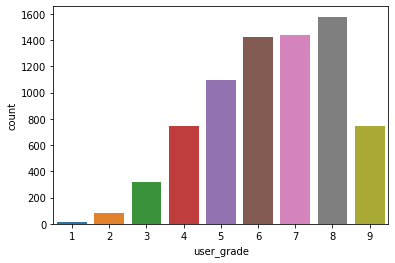

In [52]:
sns.countplot(ddd['user_grade'])
plt.show()

In [54]:
for i in range(1,10):
    count = len(ddd[ddd['user_grade']==i])
    dense = round(count/7442 , 2)
    print(f'grade={i} : count = ', count, '/ dense =', dense )

grade=1 : count =  12 / dense = 0.0
grade=2 : count =  81 / dense = 0.01
grade=3 : count =  323 / dense = 0.04
grade=4 : count =  748 / dense = 0.1
grade=5 : count =  1097 / dense = 0.15
grade=6 : count =  1424 / dense = 0.19
grade=7 : count =  1436 / dense = 0.19
grade=8 : count =  1578 / dense = 0.21
grade=9 : count =  743 / dense = 0.1


## PCA

In [87]:
df.columns

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'index', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'user_grade', 'sec_time', 'solve_time',
       'wrongP_time', 'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean',
       'ItemID_sum', 'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'test_size', 'retest',
       'test_level', 'problem_number', 'test_tag_cumsum',
       'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew'],
      dtype='object')

In [59]:
fi.sort_values('importance',ascending=False)

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,importance
0,user_acc,2657,2516,2364,2864,3716,2823.4
13,solve_time,2622,2596,2459,2771,3462,2782.0
35,test_tag_cumsum,2099,1986,1841,2344,2868,2227.6
38,userID-solve_time-skew,2063,1968,1847,2143,2984,2201.0
36,userID-solve_time-mean,1850,1929,1905,2011,2773,2093.6
12,sec_time,1786,1837,1604,2042,2831,2020.0
15,correctP_time,1901,1849,1722,2040,2569,2016.2
37,userID-solve_time-std,1893,1762,1641,2034,2739,2013.8
14,wrongP_time,1861,1771,1606,1901,2336,1895.0
18,ItemID_mean,1711,1601,1616,1829,2124,1776.2


In [77]:
# 표준화 먼저
from sklearn.preprocessing import StandardScaler
x = df.drop(['Unnamed: 0','userID','assessmentItemID', 'testId', 'answerCode','Timestamp', 'KnowledgeTag', 'index'],axis=1).values
y = df['answerCode'].values

x = StandardScaler().fit_transform(x)

features = ['user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'user_grade', 'sec_time', 'solve_time',
       'wrongP_time', 'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean',
       'ItemID_sum', 'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'test_size', 'retest',
       'test_level', 'problem_number', 'test_tag_cumsum',
       'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew']
pd.DataFrame(x, columns=features).head()

,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,-1.063891,-1.144843,-3.594444,-1.255203,-1.051930,-0.505014,-0.892700,-0.791063,-0.489867,2.051233,0.532485,-1.998149,1.654511,-1.332833,1.202195,2.219569,0.772821,-1.437611,-0.385819,-1.162511,-0.896365,2.070244,0.716907,1.675081,0.830422,2.201030,-1.278573,-1.700852,-2.466752,-1.177128,-0.853826,-1.303932,-1.570684,-1.431245,-2.001039,0.717072,-0.267591,-0.140867,0.532485,-1.332833,-0.540028,-0.748043,-0.300009,1.65242
1,-1.058980,-1.141282,1.848787,-0.812604,-0.504489,0.969538,-0.892700,-0.791063,-0.489867,2.051233,0.532485,-1.998149,1.603660,-0.841335,0.822326,1.928807,0.772821,-1.437610,-0.385819,0.661010,-1.504899,2.070244,0.716907,1.593707,0.771608,1.908233,0.416179,-1.700852,-2.466752,-1.177128,-1.571129,-1.597960,0.701645,-1.681408,-1.826716,1.106062,-0.267591,-0.140867,0.532485,-0.841335,-0.534254,-0.748043,-0.300009,1.65242
2,-1.054068,-1.137720,1.848787,-0.370005,0.042952,0.969538,-0.634988,-0.464625,1.021947,2.051233,0.532485,-1.998149,1.349406,-0.349838,0.442457,1.928807,0.772821,-1.437609,-0.357798,-0.409169,-1.229187,2.070244,0.716907,1.329243,0.580462,1.908233,0.416179,-1.700852,-2.466752,-1.177128,-1.234895,-1.400858,-0.143371,-1.681408,-1.826716,1.106062,-0.267591,-0.140867,0.532485,-0.349838,-0.518857,-0.748043,-0.300009,1.65242
3,-1.049157,-1.134158,1.848787,0.072593,0.590392,0.969538,-0.377277,-0.138187,1.021947,2.051233,0.532485,-1.998149,1.603660,0.141659,0.062588,1.928807,0.772821,-1.437608,-0.363402,-1.366525,-1.334403,2.070244,0.716907,1.614050,0.786311,1.908233,0.416179,-1.700852,-2.466752,-1.177128,-1.422076,-1.701384,-1.070249,-1.681408,-1.826716,1.106062,-0.267591,-0.140867,0.532485,0.141659,-0.505384,-0.748043,-0.300009,1.65242
4,-1.044245,-1.130596,1.848787,0.515192,1.137833,0.969538,-0.119566,0.188251,1.021947,2.051233,0.532485,-1.998149,1.501958,0.633157,-0.697150,1.928807,0.772821,-1.437607,-0.363402,-1.274879,-1.355224,2.070244,0.716907,1.491990,0.698090,1.908233,0.416179,-1.700852,-2.466752,-1.177128,-1.451886,-1.596694,0.163560,-1.681408,-1.826716,1.106062,-0.267591,-0.140867,0.532485,0.633157,-0.491911,-0.748043,-0.300009,1.65242


In [102]:
from  sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_comp = pca.fit_transform(x)

pca_result = pd.DataFrame(data=pca_comp, columns =['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13','pc14','pc15','pc16','pc17','pc18','pc19','pc20'])  #
pca_result

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
0,-5.185750,-0.065200,-4.166713,-1.505214,-0.063587,-0.212926,-0.740853,-0.010369,-0.453469,2.618331,-2.897351,1.821556,2.618085,-0.927557,-1.189288,1.206503,0.237781,-1.118401,1.830445,-0.473707
1,-6.067069,-0.508276,-2.168970,-0.948440,0.972167,-1.424612,-0.282996,-0.530500,-0.399046,0.427963,-1.362461,1.391593,2.332086,-0.288777,1.597134,-0.681955,-0.316387,-2.506522,-0.439479,0.818058
2,-5.789269,-1.321563,-1.080169,-0.979790,1.045105,-1.879803,0.035973,-1.104023,-0.536847,0.586479,-1.627158,1.570576,2.273718,-0.183813,1.235986,-0.530783,-0.418257,-2.131771,-0.461615,0.716215
3,-5.911274,-2.257555,-0.539284,-1.093709,0.911301,-1.410374,0.350527,-1.388237,-1.230070,0.887210,-2.013021,1.825447,2.290216,-0.059342,1.188995,-0.581980,-0.617577,-1.668538,-0.630476,0.408683
4,-5.776008,-3.118458,0.227317,-1.387185,0.721244,-1.369840,0.095193,-1.135400,-1.109856,0.361423,-1.475949,1.535998,2.027279,-0.730099,1.397786,-0.525187,-0.547682,-2.127803,-0.612327,0.307655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,0.669346,0.024653,-0.354593,-3.171777,-1.922332,1.351379,0.445257,-0.369432,2.226744,1.099494,-0.022353,-1.133248,-0.923203,0.224506,0.178739,0.627248,0.401166,-0.395650,1.405882,-0.212018
2525952,-1.126415,1.863361,-3.193871,-1.429018,-1.034216,0.514951,1.546892,-1.209912,0.866165,1.949703,0.371303,-1.491111,-1.124676,-0.110886,-0.489780,1.361407,0.074781,-0.159303,1.233873,-0.122144
2525953,-1.310135,1.187998,-1.663592,-1.261542,-0.524171,-0.753643,1.708675,-1.986997,0.504915,1.610291,0.724933,-1.617849,-1.303371,-0.330762,-0.575002,1.457038,-0.148222,-0.226741,1.066045,-0.294996
2525954,-2.055774,0.421087,-1.141515,-1.374103,-0.424584,-0.623260,1.276399,-1.274377,-0.351167,0.777939,2.084805,-2.028890,-1.898264,-1.552791,0.198530,1.414473,-0.456920,-0.950599,0.805023,-0.646178


In [103]:
pca.explained_variance_ratio_   # 각 주성분의 설명력

array([0.24839104, 0.13989019, 0.10447501, 0.05782367, 0.049888  ,
       0.036563  , 0.03593876, 0.03388859, 0.03272661, 0.02757658,
       0.02658882, 0.02489904, 0.02318401, 0.02024096, 0.01749109,
       0.01460624, 0.01173884, 0.01148211, 0.01012147, 0.00976932])

In [104]:
sum(pca.explained_variance_ratio_)

0.9372833486616086

In [97]:
from  sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_comp = pca.fit_transform(x)

pca_result = pd.DataFrame(data=pca_comp, columns =['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10'])  #,'pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13','pc14','pc15','pc16','pc17','pc18','pc19','pc20'
pca_result

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-5.185748,-0.065184,-4.166631,-1.506342,-0.061604,-0.208102,-0.736469,-0.013961,-0.458714,2.619576
1,-6.067070,-0.508285,-2.168993,-0.946463,0.971204,-1.420384,-0.280708,-0.527329,-0.394844,0.439594
2,-5.789271,-1.321562,-1.080183,-0.978379,1.044542,-1.874427,0.039534,-1.100815,-0.532917,0.596508
3,-5.911274,-2.257548,-0.539284,-1.092896,0.910940,-1.405593,0.354030,-1.385206,-1.226999,0.893650
4,-5.776009,-3.118452,0.227318,-1.386387,0.720923,-1.365510,0.098238,-1.132628,-1.107134,0.367041
...,...,...,...,...,...,...,...,...,...,...
2525951,0.669347,0.024660,-0.354572,-3.172915,-1.921842,1.349462,0.444731,-0.371042,2.224209,1.093503
2525952,-1.126414,1.863364,-3.193858,-1.429601,-1.034143,0.512977,1.546333,-1.210534,0.864390,1.946758
2525953,-1.310134,1.188001,-1.663580,-1.262293,-0.524157,-0.756724,1.706819,-1.987294,0.502865,1.605242
2525954,-2.055773,0.421090,-1.141498,-1.375095,-0.424542,-0.627378,1.273569,-1.274634,-0.353564,0.768938


In [98]:
pca.explained_variance_ratio_ 

array([0.24839104, 0.13989019, 0.10447501, 0.05782365, 0.04988799,
       0.03656269, 0.03593857, 0.03388851, 0.0327264 , 0.02757585])

In [99]:
sum(pca.explained_variance_ratio_)

0.7671599025777175

In [90]:
df.head()

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,0.0,0,0.0,0.5,0,0.0,0.5,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984,246.0,0.957333,718.0,25.495403,46.57444,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,6.0,0.0,6.0,1.0,3.0,46.773103,132.41593,12.619452
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.0,1,1.0,1.0,0,0.0,0.5,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968,242.0,0.917067,3439.0,25.495403,46.57444,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,6.0,0.0,6.0,2.0,6.0,46.773103,132.41593,12.619452
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.0,2,2.0,1.0,1,1.0,1.0,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916,229.0,0.917067,3439.0,25.495403,46.57444,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,6.0,0.0,6.0,3.0,14.0,46.773103,132.41593,12.619452
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.0,3,3.0,1.0,2,2.0,1.0,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972,243.0,0.917067,3439.0,25.495403,46.57444,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,6.0,0.0,6.0,4.0,21.0,46.773103,132.41593,12.619452
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.0,4,4.0,1.0,3,3.0,1.0,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948,237.0,0.917067,3439.0,25.495403,46.57444,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,6.0,0.0,6.0,5.0,28.0,46.773103,132.41593,12.619452


In [101]:
# pca (train에 필요한)주요 컬럼들 concat
df_main = df.loc[:,['userID', 'answerCode', 'Timestamp', 'user_grade']]
df_main

,userID,answerCode,Timestamp,user_grade
0,0,1,2020-03-24 00:17:11,8
1,0,1,2020-03-24 00:17:14,8
2,0,1,2020-03-24 00:17:22,8
3,0,1,2020-03-24 00:17:29,8
4,0,1,2020-03-24 00:17:36,8
...,...,...,...,...
2525951,7441,0,2020-06-05 06:50:21,4
2525952,7441,1,2020-08-21 01:06:39,4
2525953,7441,1,2020-08-21 01:06:50,4
2525954,7441,1,2020-08-21 01:07:36,4


In [106]:
train = pd.concat([df_main,pca_result], axis=1)
train

,userID,answerCode,Timestamp,user_grade,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
0,0,1,2020-03-24 00:17:11,8,-5.185750,-0.065200,-4.166713,-1.505214,-0.063587,-0.212926,-0.740853,-0.010369,-0.453469,2.618331,-2.897351,1.821556,2.618085,-0.927557,-1.189288,1.206503,0.237781,-1.118401,1.830445,-0.473707
1,0,1,2020-03-24 00:17:14,8,-6.067069,-0.508276,-2.168970,-0.948440,0.972167,-1.424612,-0.282996,-0.530500,-0.399046,0.427963,-1.362461,1.391593,2.332086,-0.288777,1.597134,-0.681955,-0.316387,-2.506522,-0.439479,0.818058
2,0,1,2020-03-24 00:17:22,8,-5.789269,-1.321563,-1.080169,-0.979790,1.045105,-1.879803,0.035973,-1.104023,-0.536847,0.586479,-1.627158,1.570576,2.273718,-0.183813,1.235986,-0.530783,-0.418257,-2.131771,-0.461615,0.716215
3,0,1,2020-03-24 00:17:29,8,-5.911274,-2.257555,-0.539284,-1.093709,0.911301,-1.410374,0.350527,-1.388237,-1.230070,0.887210,-2.013021,1.825447,2.290216,-0.059342,1.188995,-0.581980,-0.617577,-1.668538,-0.630476,0.408683
4,0,1,2020-03-24 00:17:36,8,-5.776008,-3.118458,0.227317,-1.387185,0.721244,-1.369840,0.095193,-1.135400,-1.109856,0.361423,-1.475949,1.535998,2.027279,-0.730099,1.397786,-0.525187,-0.547682,-2.127803,-0.612327,0.307655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,0,2020-06-05 06:50:21,4,0.669346,0.024653,-0.354593,-3.171777,-1.922332,1.351379,0.445257,-0.369432,2.226744,1.099494,-0.022353,-1.133248,-0.923203,0.224506,0.178739,0.627248,0.401166,-0.395650,1.405882,-0.212018
2525952,7441,1,2020-08-21 01:06:39,4,-1.126415,1.863361,-3.193871,-1.429018,-1.034216,0.514951,1.546892,-1.209912,0.866165,1.949703,0.371303,-1.491111,-1.124676,-0.110886,-0.489780,1.361407,0.074781,-0.159303,1.233873,-0.122144
2525953,7441,1,2020-08-21 01:06:50,4,-1.310135,1.187998,-1.663592,-1.261542,-0.524171,-0.753643,1.708675,-1.986997,0.504915,1.610291,0.724933,-1.617849,-1.303371,-0.330762,-0.575002,1.457038,-0.148222,-0.226741,1.066045,-0.294996
2525954,7441,1,2020-08-21 01:07:36,4,-2.055774,0.421087,-1.141515,-1.374103,-0.424584,-0.623260,1.276399,-1.274377,-0.351167,0.777939,2.084805,-2.028890,-1.898264,-1.552791,0.198530,1.414473,-0.456920,-0.950599,0.805023,-0.646178


#### test data 도 pca로 만들기

In [109]:
test_df.head()

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,user_grade
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660,165.0,0.636571,1114.0,86.859167,192.63509,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,7.0,0.0,5.0,1.0,26.0,61.148649,108.448444,9.761547,5
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620,155.0,0.636571,1114.0,86.859167,192.63509,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,7.0,0.0,5.0,2.0,52.0,61.148649,108.448444,9.761547,5
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548,137.0,0.663200,1658.0,86.859167,192.63509,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,7.0,0.0,5.0,3.0,146.0,61.148649,108.448444,9.761547,5
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636,159.0,0.663200,1658.0,86.859167,192.63509,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,7.0,0.0,5.0,4.0,151.0,61.148649,108.448444,9.761547,5
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304,76.0,0.570222,2566.0,86.859167,192.63509,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,7.0,0.0,5.0,6.0,158.0,61.148649,108.448444,9.761547,5


In [111]:
len(test_df.columns)

52

In [113]:
test_df['user_acc'] = test_df['user_acc'].fillna(0)
test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,user_grade
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,0.000000,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,7.0,0.0,5.0,1.0,26.0,61.148649,108.448444,9.761547,5
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,7.0,0.0,5.0,2.0,52.0,61.148649,108.448444,9.761547,5
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,7.0,0.0,5.0,3.0,146.0,61.148649,108.448444,9.761547,5
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,7.0,0.0,5.0,4.0,151.0,61.148649,108.448444,9.761547,5
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,7.0,0.0,5.0,6.0,158.0,61.148649,108.448444,9.761547,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.218750,41.531903,2.579163,4
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.218750,41.531903,2.579163,4
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.218750,41.531903,2.579163,4
260112,260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,260112,10.0,14,0.714286,3,2.0,0.67,1,1.0,1.0,0.64,4,30,0.83,4,0.66,0.77,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,249.0,0.765442,917.0,64.891324,139.460022,9.389976,72.882244,135.040350,4.853693,56.244580,143.539425,8.551274,5.0,0.0,4.0,4.0,139.5,36.218750,

In [114]:
# 결측치 개수 확인
test_df.isnull().sum()  # 없음

Unnamed: 0                0
userID                    0
assessmentItemID          0
testId                    0
answerCode                0
Timestamp                 0
KnowledgeTag              0
index                     0
user_correct_answer       0
user_total_answer         0
user_acc                  0
u_test_cnt                0
test_ans_cnt              0
test_ans_rate             0
u_tag_cnt                 0
tag_ans_cnt               0
tag_ans_rate              0
test_rate                 0
grade                     0
grade_test_level          0
que_rate                  0
que_num                   0
que_num_rate              0
tag_rate                  0
sec_time                  0
solve_time                0
wrongP_time               0
correctP_time             0
test_mean                 0
test_sum                  0
ItemID_mean               0
ItemID_sum                0
tag_mean                  0
tag_sum                   0
test_t_mean               0
test_t_std          

In [115]:
# 표준화 먼저
from sklearn.preprocessing import StandardScaler
t_x = test_df.drop(['Unnamed: 0','userID','assessmentItemID', 'testId', 'answerCode','Timestamp', 'KnowledgeTag', 'index'],axis=1).values
t_y = test_df['answerCode'].values

t_x = StandardScaler().fit_transform(t_x)

features = ['user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'user_grade', 'sec_time', 'solve_time',
       'wrongP_time', 'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean',
       'ItemID_sum', 'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'test_size', 'retest',
       'test_level', 'problem_number', 'test_tag_cumsum',
       'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew']
pd.DataFrame(t_x, columns=features).head()

,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,-1.127238,-1.199836,-3.741519,-1.275515,-1.067249,-0.506628,-0.905407,-0.798764,-0.490468,-0.724519,0.121968,1.199148,0.027739,-1.332532,1.202735,-0.110614,-2.347859,-0.256272,1.655065,0.058113,-0.727665,-0.626727,0.027711,-0.356137,-0.135614,-1.039737,0.551252,0.466805,-0.518476,0.713197,0.969036,0.817143,0.905342,1.123024,-0.085755,0.374224,-0.124725,0.121968,-1.332532,-0.496662,-0.310788,-0.60362,0.792163,-1.08142
1,-1.122053,-1.196122,1.915831,-0.821737,-0.507272,0.967889,-0.635635,-0.460053,1.020921,-0.724519,0.121968,1.199148,-0.175322,-0.842161,0.823515,-0.110614,-2.347855,-0.256272,1.169025,0.032933,-0.727665,-0.626727,-0.175379,-0.503029,-0.135614,-1.039737,0.551252,0.466805,-0.518476,0.539868,1.085374,0.436628,0.905342,1.123024,-0.085755,0.374224,-0.124725,0.121968,-0.842161,-0.445611,-0.310788,-0.60362,0.792163,-1.08142
2,-1.116869,-1.192408,1.915831,-0.367958,0.052705,0.967889,-0.905407,-0.798764,-0.490468,-0.724519,0.121968,1.199148,-0.530679,-0.351791,0.444296,0.034961,-2.347842,0.130334,1.261681,1.072400,-0.727665,-0.626727,-0.540940,-0.767433,0.058257,-0.699926,0.551252,0.466805,-0.518476,1.355409,0.438139,-1.228382,1.278584,1.030081,-1.251313,0.374224,-0.124725,0.121968,-0.351791,-0.261042,-0.310788,-0.60362,0.792163,-1.08142
3,-1.116869,-1.188694,0.030048,0.085821,0.052705,-0.005292,-0.635635,-0.798764,-2.001858,-0.724519,0.121968,1.199148,-0.073791,0.138580,0.065077,0.034961,-2.347841,-0.375665,-0.729215,-0.203424,-0.727665,-0.626727,-0.094143,-0.444272,0.058257,-0.699926,0.551252,0.466805,-0.518476,-0.373574,-0.783665,-1.101609,1.278584,1.030081,-1.251313,0.374224,-0.124725,0.121968,0.138580,-0.251225,-0.310788,-0.60362,0.792163,-1.08142
4,-1.116869,-1.184981,-0.912844,0.539599,0.052705,-0.506628,-0.905407,-0.798764,-0.490468,-0.724519,0.121968,1.199148,-1.799812,1.119322,-1.198988,-0.620123,-2.347840,-0.364294,-0.699702,-0.352201,-0.727665,-0.626727,-1.779787,-1.663471,-0.618673,-0.132743,0.551252,0.466805,-0.518476,-0.805982,-1.289434,-1.425625,0.736281,0.713807,-1.014675,0.374224,-0.124725,0.121968,1.119322,-0.237480,-0.310788,-0.60362,0.792163,-1.08142


In [116]:
from  sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_comp = pca.fit_transform(t_x)

test_pca_result = pd.DataFrame(data=pca_comp, columns =['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13','pc14','pc15','pc16','pc17','pc18','pc19','pc20'])  #
test_pca_result

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
0,1.883710,3.313751,-2.520133,-2.493434,-0.278211,-0.695980,0.415715,0.908725,0.079521,-0.283727,0.591887,-0.111153,0.984681,-0.748687,1.129781,-1.822502,0.579751,0.116942,2.623632,-1.120233
1,1.463534,2.596955,-0.181965,-1.308305,1.225956,-1.832804,1.528165,-0.858656,-0.454710,-1.480424,1.374811,-0.078819,1.303011,0.710871,-1.646003,-0.200136,-0.000207,0.084588,0.453281,-0.147900
2,2.609617,2.516233,0.504450,-1.843465,0.971136,-0.939673,0.973179,-1.282572,-0.185409,-0.727367,0.212880,-0.693384,1.808007,1.665875,-1.456869,0.446917,0.363381,0.103675,0.114621,-0.243679
3,1.958276,0.641284,-0.959986,-2.437183,0.054132,1.486638,1.057930,-0.919569,-1.620867,-0.394681,0.189280,-0.817555,1.415357,0.776517,-0.947155,-0.055827,0.590969,0.402663,0.881317,-0.133384
4,3.234959,-1.414282,-0.379037,-2.935321,-0.210896,1.558768,1.536528,-1.871757,-0.142299,-0.545742,-0.017709,-1.174895,1.259578,0.818566,-0.025831,-0.367629,0.913569,0.227496,1.513686,0.400974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,0.274325,2.097180,-2.389321,-0.921440,-0.709819,-0.049221,1.220760,-2.061544,1.445795,0.946496,0.496838,1.837318,-0.436658,1.391373,-0.310798,-0.705303,0.726133,-0.384492,-0.545892,0.872205
260110,0.549931,1.707495,-2.705824,-1.585690,-1.457488,1.057724,0.208868,-0.695306,1.777730,0.636423,1.028827,2.255861,-0.783841,0.615629,-1.089034,-0.629003,0.773229,-0.903668,-0.636124,0.637869
260111,-1.746218,0.777350,-2.051475,-1.340656,-0.523399,0.957684,0.022449,-1.931965,-0.566846,1.252795,0.964728,1.891138,-0.405810,0.345652,-0.702950,-0.893695,-0.832545,-0.427001,-0.714771,-0.517662
260112,-1.328634,0.463376,-0.413053,-1.325369,-0.245847,0.117855,0.140563,-2.507526,-0.428699,1.647002,0.449562,1.523925,-0.239746,0.728237,-0.267487,-0.937270,-1.136138,-0.024651,-0.933860,-1.077595


In [117]:
pca.explained_variance_ratio_   # 각 주성분의 설명력

array([0.25050289, 0.1399065 , 0.10422272, 0.05861875, 0.04946367,
       0.03623176, 0.03567392, 0.03390043, 0.03241504, 0.02731009,
       0.02613747, 0.02520612, 0.02273668, 0.02001792, 0.01708326,
       0.0155237 , 0.01167911, 0.01139201, 0.00995464, 0.00967307])

In [118]:
sum(pca.explained_variance_ratio_)

0.9376497792787607

In [119]:
test_df_main = test_df.loc[:,['userID', 'answerCode', 'Timestamp', 'user_grade']]
test_df_main

,userID,answerCode,Timestamp,user_grade
0,3,1,2020-01-09 10:56:31,5
1,3,1,2020-01-09 10:56:57,5
2,3,0,2020-01-09 10:58:31,5
3,3,0,2020-01-09 10:58:36,5
4,3,0,2020-01-09 10:58:43,5
...,...,...,...,...
260109,7439,0,2020-10-14 23:07:23,4
260110,7439,1,2020-10-14 23:07:41,4
260111,7439,1,2020-10-14 23:08:02,4
260112,7439,1,2020-10-14 23:09:31,4


In [120]:
test = pd.concat([test_df_main, test_pca_result], axis=1)
test

,userID,answerCode,Timestamp,user_grade,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
0,3,1,2020-01-09 10:56:31,5,1.883710,3.313751,-2.520133,-2.493434,-0.278211,-0.695980,0.415715,0.908725,0.079521,-0.283727,0.591887,-0.111153,0.984681,-0.748687,1.129781,-1.822502,0.579751,0.116942,2.623632,-1.120233
1,3,1,2020-01-09 10:56:57,5,1.463534,2.596955,-0.181965,-1.308305,1.225956,-1.832804,1.528165,-0.858656,-0.454710,-1.480424,1.374811,-0.078819,1.303011,0.710871,-1.646003,-0.200136,-0.000207,0.084588,0.453281,-0.147900
2,3,0,2020-01-09 10:58:31,5,2.609617,2.516233,0.504450,-1.843465,0.971136,-0.939673,0.973179,-1.282572,-0.185409,-0.727367,0.212880,-0.693384,1.808007,1.665875,-1.456869,0.446917,0.363381,0.103675,0.114621,-0.243679
3,3,0,2020-01-09 10:58:36,5,1.958276,0.641284,-0.959986,-2.437183,0.054132,1.486638,1.057930,-0.919569,-1.620867,-0.394681,0.189280,-0.817555,1.415357,0.776517,-0.947155,-0.055827,0.590969,0.402663,0.881317,-0.133384
4,3,0,2020-01-09 10:58:43,5,3.234959,-1.414282,-0.379037,-2.935321,-0.210896,1.558768,1.536528,-1.871757,-0.142299,-0.545742,-0.017709,-1.174895,1.259578,0.818566,-0.025831,-0.367629,0.913569,0.227496,1.513686,0.400974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,0,2020-10-14 23:07:23,4,0.274325,2.097180,-2.389321,-0.921440,-0.709819,-0.049221,1.220760,-2.061544,1.445795,0.946496,0.496838,1.837318,-0.436658,1.391373,-0.310798,-0.705303,0.726133,-0.384492,-0.545892,0.872205
260110,7439,1,2020-10-14 23:07:41,4,0.549931,1.707495,-2.705824,-1.585690,-1.457488,1.057724,0.208868,-0.695306,1.777730,0.636423,1.028827,2.255861,-0.783841,0.615629,-1.089034,-0.629003,0.773229,-0.903668,-0.636124,0.637869
260111,7439,1,2020-10-14 23:08:02,4,-1.746218,0.777350,-2.051475,-1.340656,-0.523399,0.957684,0.022449,-1.931965,-0.566846,1.252795,0.964728,1.891138,-0.405810,0.345652,-0.702950,-0.893695,-0.832545,-0.427001,-0.714771,-0.517662
260112,7439,1,2020-10-14 23:09:31,4,-1.328634,0.463376,-0.413053,-1.325369,-0.245847,0.117855,0.140563,-2.507526,-0.428699,1.647002,0.449562,1.523925,-0.239746,0.728237,-0.267487,-0.937270,-1.136138,-0.024651,-0.933860,-1.077595


In [121]:
import os,gc
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, accuracy_score

#폴드 개수만큼 user를 쪼갠 목록을 만든다
def lgbm_oof_split_data_withidx(n_fold, df):
    #grade별로 user list 생성 (9개)
    u_g = df.groupby(['userID','user_grade'])['userID'].count().reset_index(name='cnt')   #user별 grade값
    users = [[] for _ in range(10)]  #grade개수총 9개

    for id in u_g['userID']:
        id_grade = int(u_g[u_g['userID'] == id]['user_grade'])  #해당 유저의 grade
        id_cnt = int(u_g[u_g['userID'] == id]['cnt'])
        users[id_grade].append((id, id_cnt))
    
    # grade별로 sorted
    for i in range(1,10):
        user_list = users[i]
        user_list = sorted(user_list, key =lambda x: x[1], reverse=True)
        users[i] = user_list
    

    n_fold = n_fold
    random.seed(37)  # default 42
    user_id_dict=defaultdict(list)
    user_count_dict=defaultdict(int)

    for i in range(1,10):
        gul = users[i]           # gul = grade user list
        random.shuffle(gul)
        for idx, (id, cnt) in enumerate(gul):
            f_num=idx%n_fold
            user_count_dict[f_num] += cnt
            user_id_dict[f_num].append(id)

    return user_id_dict,user_count_dict



#dict들을 통해 원하는 폴드의 train/val set을 가져온다
def get_fold_data(idx,data,user_id_dict,user_count_dict):
    
    train = data[data['userID'].isin(user_id_dict[idx]) == False]  # train
    test = data[data['userID'].isin(user_id_dict[idx])] # validation

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]  #validation
    return train, test




#FE를 진행한 전체 train set과 FE를 진행한 전체 test set, featrue 들을 넣어주시면 됩니다
def make_lgb_user_oof_prediction(train, test, FEATS,  model_params=None, folds=None ):  # categorical_features='auto',
    
#     train.shape[0]  # train 행 총 개수
    
    # fold 생성
    user_id_dict,user_count_dict = lgbm_oof_split_data_withidx(folds, train)
    
    # 마지막 interaction만 추출 (test dataset)
#     test = test[test['userID'] != test['userID'].shift(-1)]  # 마지막 interaction
    test = test[test['answerCode'] == -1]
    x_test = test[FEATS] # 마지막 interaction의 features 값
    
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수 (예측 데이터? 예측값?)
    y_oof = np.zeros(train.shape[0])
    
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    acc=0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = FEATS

    
    for fold in range(folds):

        # train index, validation index로 train 데이터를 나눔
        train_set,valid_set = get_fold_data(fold, train, user_id_dict, user_count_dict)  #개수 잘 나뉘었다.
   

        x_tr, x_val = train_set[FEATS], valid_set[FEATS]    # 정답 외 feature 값들 (마지막 interaction만 X)
        y_tr, y_val = train_set['answerCode'], valid_set['answerCode']  # 정답 부분
    
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        model = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature='auto',
            verbose_eval=100,    
            num_boost_round=5000,
        )

        # Validation 데이터 예측
        val_preds = model.predict(x_val)
        
        # Validation index에 예측값 저장 
#         y_oof[fold] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
#         acc += accuracy_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += model.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = model.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score} ") # 폴드별 Validation 스코어 출력
#     print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
    
    
    
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return test_preds, fi  # 예측 결과, feature 중요도 반환
        
        
        
#         # Validation index에 예측값 저장 
#         y_oof[fold] = val_preds
        
#         # 폴드별 Validation 스코어 측정
#         fold_acc = accuracy_score(y_val, list(map(round,val_preds)))
#         print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)} | ACC: {fold_acc}")
#         print('-'*80)

#         # score 변수에 폴드별 평균 Validation 스코어 저장
#         score += roc_auc_score(y_val, val_preds) / folds
#         acc+=fold_acc / folds
#         # 테스트 데이터 예측하고 평균해서 저장
#         test_preds += model.predict(x_test) / folds
        
#         # 폴드별 피처 중요도 저장
#         fi[f'fold_{fold+1}'] = model.feature_importance()

#         del x_tr, x_val, y_tr, y_val
#         gc.collect()
        
#     print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
#     # print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
    
#     # 폴드별 피처 중요도 평균값 계산해서 저장 
#     fi_cols = [col for col in fi.columns if 'fold_' in col]
#     fi['importance'] = fi[fi_cols].mean(axis=1)
    
    
#     return model, test_preds, fi  #y_oof, 

In [122]:
FEATS = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13','pc14','pc15','pc16','pc17','pc18','pc19','pc20' ]

model_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'metric':'auc',
        'num_leaves': 256,
#         'max_bin': 204,
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': 38,
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': 0.6623969601759928,         # optuna 추천 - 0.46948747908887395
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': 0.5877385312344033,
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': 6,   # 1
#         'n_estimators': 100, # 트리 개수
        'early_stopping_rounds': 100,
#         # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l1': 8.755042100872112e-06,       # 0.00010175824628083187
#         # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l2': 0.0015429233553149078,    # 0.0001150682989588032
        'seed': 37,
        'verbose': -1,
        'n_jobs': -1,    
    }


test_preds, fi = make_lgb_user_oof_prediction(train, test, FEATS,  model_params, folds=5)  #categorical_features='auto',
# print_score(label, pred, prob_thres=0.5)

fold: 1, x_tr.shape: (2013192, 20), x_val.shape: (1493, 20)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.839206	valid_1's auc: 0.810387
[200]	training's auc: 0.848751	valid_1's auc: 0.810401
[300]	training's auc: 0.856511	valid_1's auc: 0.812972
[400]	training's auc: 0.863785	valid_1's auc: 0.812575
Early stopping, best iteration is:
[329]	training's auc: 0.858689	valid_1's auc: 0.81367
Fold 1 | AUC: 0.8136696208675643
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (2032421, 20), x_val.shape: (1491, 20)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.839012	valid_1's auc: 0.816996
[200]	training's auc: 0.848466	valid_1's auc: 0.820463
[300]	training's auc: 0.856184	valid_1's auc: 0.8222
[400]	training's auc: 0.863445	valid_1's auc: 0.821851
Early stopping, best iteration is:
[311]	training's auc: 0.856989	valid_1's auc: 0.82318
Fold 2 | AUC: 0.8231796662

In [123]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "output22.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(test_preds):  #test_preds   /  total_preds
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output22.csv


In [36]:
df_jh_1.describe()

,Unnamed: 0,userID,answerCode,KnowledgeTag,level,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,item_ans_rate,rank_point,user_correct_answer,user_total_answer,user_acc,user_correct_answer_tag,user_total_answer_tag,user_acc_tag,sec_time,solve_time,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,grade,test_level
count,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.118767e+06,2.525956e+06,2.118767e+06,2.033649e+06,2.525956e+06,2.033649e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06
mean,1.262978e+06,2.082610e+03,6.546385e-01,4.908872e+03,3.780479e+00,2.522158e-01,2.643989e-01,2.522213e-01,6.546385e-01,8.752170e+02,2.290858e+00,2.835984e+00,7.040826e-01,3.009981e+00,3.463954e+00,7.011368e-01,1.595085e+09,7.184480e+01,7.184480e+01,1.692457e+02,9.485875e+00,7.184480e+01,1.574057e+02,7.299994e+00,7.184480e+01,1.721328e+02,9.649431e+00,4.705087e+00,5.359726e+00
std,7.291808e+05,1.585106e+03,4.754861e-01,3.302930e+03,8.049330e-01,1.401556e-01,1.232310e-01,1.340379e-01,1.966243e-01,2.786275e+02,1.769811e+00,2.259383e+00,3.609862e-01,3.144869e+00,3.880314e+00,3.576183e-01,7.008916e+06,1.784383e+02,2.725069e+01,4.972988e+01,2.760465e+00,3.703376e+01,7.624349e+01,2.745547e+00,2.322061e+01,4.102101e+01,2.463727e+00,2.431831e+00,2.342591e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,1.000000e+00,-1.200000e-01,-4.000000e-02,-4.666667e-02,4.333333e-02,-3.310000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.577805e+09,0.000000e+00,2.266831e+01,4.168866e+01,3.020772e+00,1.104167e+01,1.112865e+01,7.431878e-01,2.225320e+01,3.134707e+01,2.063371e+00,1.000000e+00,1.175000e+00
25%,6.314888e+05,8.000000e+02,0.000000e+00,1.934000e+03,3.000000e+00,1.500000e-01,1.653333e-01,1.551454e-01,5.014327e-01,7.750000e+02,1.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00,1.000000e+00,5.000000e-01,1.589865e+09,1.100000e+01,5.191038e+01,1.350719e+02,7.566944e+00,4.626851e+01,9.825582e+01,5.264741e+00,5.588423e+01,1.413882e+02,7.872676e+00,3.000000e+00,3.456667e+00
50%,1.262978e+06,1.748000e+03,1.000000e+00,5.258000e+03,4.000000e+00,2.400000e-01,2.552063e-01,2.440000e-01,6.666667e-01,9.360000e+02,2.000000e+00,3.000000e+00,8.750000e-01,2.000000e+00,2.000000e+00,8.461538e-01,1.596092e+09,2.900000e+01,6.492609e+01,1.643223e+02,9.055159e+00,6.408200e+01,1.473574e+02,6.888123e+00,6.578595e+01,1.672628e+02,9.344459e+00,5.000000e+00,5.488000e+00
75%,1.894466e+06,3.034000e+03,1.000000e+00,7.913000e+03,4.000000e+00,3.333333e-01,3.352000e-01,3.240000e-01,8.257143e-01,1.004000e+03,3.000000e+00,4.000000e+00,1.000000e+00,4.000000e+00,5.000000e+00,1.000000e+00,1.600687e+09,6.650000e+01,8.695452e+01,2.005754e+02,1.083373e+01,8.774286e+01,2.066990e+02,8.895637e+00,8.455804e+01,1.991193e+02,1.100484e+01,7.000000e+00,7.436000e+00
max,2.525955e+06,7.441000e+03,1.000000e+00,1.127100e+04,5.000000e+00,8.400000e-01,5.998998e-01,8.000000e-01,9.966667e-01,3.091000e+03,2.300000e+01,2.600000e+01,1.000000e+00,6.100000e+01,1.070000e+02,1.000000e+00,1.609260e+09,3.600000e+03,2.352491e+02,3.983627e+02,2.882578e+01,4.440746e+02,6.009421e+02,1.827149e+01,1.905440e+02,4.699372e+02,2.350544e+01,9.000000e+00,9.920000e+00


In [37]:
-3.310000e+03

-3310.0

In [38]:
3.091000e+03

3091.0

In [60]:
df.columns

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'index', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'user_grade', 'sec_time', 'solve_time',
       'wrongP_time', 'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean',
       'ItemID_sum', 'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'problem_number',
       'test_tag_cumsum', 'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point',
       'test_level', 'item_ans_Rate'],
      dtype='object')

# Feature Selection

In [65]:
# 표준화 먼저
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

x = df.drop(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'index', 'rank_point'], axis=1).values
y = df['answerCode'].values

x = StandardScaler().fit_transform(x)

features = [ 'user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'user_grade', 'sec_time', 'solve_time',
       'wrongP_time', 'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean',
       'ItemID_sum', 'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'problem_number',
       'test_tag_cumsum', 'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 
       'test_level', 'item_ans_Rate']  
d = pd.DataFrame(x, columns=features).head()

In [1]:
from sklearn.ensemble import ExtraTreesClassifier

etc_model = ExtraTreesClassifier()
etc_model = etc_model.fit(x, y)

print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(d.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)  #[:8]

NameError: name 'x' is not defined